High Value Customer Identification (Insiders)

# 0.0 Solution Planning (IOT)

## Input 
1. Business Issue
    - Select the most valuable customers for a loyalty program.
2. Dataset
    - E-commerce sels online, during one year period.

## Output
1. Recommendation list of customers the should be in Loyalty program.
- List: client_id | is_insider

2. Report with business answers:
- 1. Who are eligible to participate the Insiders Program?
- 2. How many customers will be part of the group?
- 3. What are the mainly characteristics of there customers?
- 4. What is the % of revenue coming of these customers?
- 5. What's the revenue expectation for this group next month?
- 6. What are the conditions for someone to be eligible for insiders?
- 7. What are the conditions for someone to be removed from insiders?
- 8. What is the guarantee that the Insiders program is best than the remaining base?
- 9. What actions the marketing team can do for increasing the revenue?

## Tasks

1. Report with business answers:
- 1. Who are eligible to participate the Insiders Program?
    - What is being eligible? What are the most valuable customers?
        - Cost:
        - Buy Experience
        - Basket Size
        - High buy likely
        - Low devolution rate.
- 2. How many customers will be part of the group?
    - Total number of customers
    - % of Insiders Group
- 3. What are the mainly characteristics of there customers?
    - Write customers characteristics:
        - Age
        - Localization
    - Write consuming characteristics:
        - Clustering Features

- 4. What is the % of revenue coming of these customers?
    - Total Revenue vs Insiders Group Revenue
- 5. What's the revenue expectation for this group next month?
    - Insiders Group LTV
    - Cohort Analysis 

- 6. What are the conditions for someone to be eligible for insiders?
    - Define the Insiders update periodicity  
    - The customers needs to be lookalike someone of the Insiders group.


- 7. What are the conditions for someone to be removed from insiders?
    - Define the Insiders update periodicity  
    - The customers needs to be unlookalike someone of the Insiders group.   


- 8. What actions the marketing team can do for increasing the revenue?
    - Discount
    - New products
    - New employees

## Solutions Benchmark
1. Desk Research

## 0.1 Import libraries

In [109]:

import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import umap.umap_ as umap
import matplotlib.pyplot as plt
from sklearn import cluster as c 
from sklearn import metrics as m
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.mixture import GaussianMixture
from scipy.cluster import hierarchy as hc 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestRegressor
from yellowbrick.cluster import SilhouetteVisualizer
from tqdm import tqdm
import os
os.chdir("P:\Python\GitHub\inside_repo")



%matplotlib inline
plt.rcParams["figure.figsize"] = (15,8)

In [108]:
!pip install -U yellowbrick
!pip list --format=freeze > requirements_dev.txt

     ---------------------------------------- 0.0/282.6 kB ? eta -:--:--
     ------------------------------- ------ 235.5/282.6 kB 4.8 MB/s eta 0:00:01
     -------------------------------------- 282.6/282.6 kB 4.4 MB/s eta 0:00:00


## 0.2 Load dataset

In [4]:
df0 = pd.read_csv('data/raw/data.csv', encoding='latin1')
df0.to_parquet('data/raw/data.parquet', index=False)
df0 = pd.read_parquet('data/raw/data.parquet')
df0.columns=df0.columns.str.lower()
df0.head(3)

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom


In [5]:
df0.T.head(1)

,0,1,2,3,4,5,6,7,8,9,...,541899,541900,541901,541902,541903,541904,541905,541906,541907,541908
invoiceno,536365,536365,536365,536365,536365,536365,536365,536366,536366,536367,...,581587,581587,581587,581587,581587,581587,581587,581587,581587,581587


# 1.0 Data Description

In [6]:
df1=df0.copy()

## 1.1 data dimensions

In [7]:
df1.shape

(541909, 8)

## 1.2 N/As

In [8]:
df1.isna().sum()/len(df1)

invoiceno      0.000000
stockcode      0.000000
description    0.002683
quantity       0.000000
invoicedate    0.000000
unitprice      0.000000
customerid     0.249267
country        0.000000
dtype: float64

## 1.3 data types

In [9]:
df1.dtypes

invoiceno       object
stockcode       object
description     object
quantity         int64
invoicedate     object
unitprice      float64
customerid     float64
country         object
dtype: object

## 1.4 descriptive statistics - numeric

In [10]:
num_attributes = df1.select_dtypes(include=['int64','float64','int32'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

In [11]:
pd.concat([num_attributes.describe(percentiles=[.5]).T,num_attributes.agg(['skew','kurtosis']).T],axis=1)

,count,mean,std,min,50%,max,skew,kurtosis
quantity,541909.0,9.552250,218.081158,-80995.00,3.00,80995.0,-0.264076,119769.160031
unitprice,541909.0,4.611114,96.759853,-11062.06,2.08,38970.0,186.506972,59005.719097
customerid,406829.0,15287.690570,1713.600303,12346.00,15152.00,18287.0,0.029835,-1.179982


### 1.4.1 negative quantity

In [12]:
#how many negative quantities there is?

aux0=num_attributes[num_attributes['quantity']<0]
print(aux0['quantity'].head(3))
print(f"There is {len(aux0)/len(num_attributes)} negative quantity")
# Because it has less than  2% of negative quantity, in this Crisp-DM circle all negatives prices will be dropped

141    -1
154    -1
235   -12
Name: quantity, dtype: int64
There is 0.019604767590130447 negative quantity


### 1.4.2 unit price

In [13]:
# inspect unitprice equal zero
aux0=num_attributes[num_attributes['unitprice']==0]
print(aux0['unitprice'].head(3))
print(f"There is {len(aux0)/len(num_attributes)} 0 quantity")

# Because it has less than  1% of negative unit price, in this Crisp-DM circle all negatives prices will be dropped

622     0.0
1970    0.0
1971    0.0
Name: unitprice, dtype: float64
There is 0.004641000610803659 0 quantity


# 2.0 Data Cleaning and Feature Filtering

## 2.1 Treat NAs

In [14]:
df2 = df1.copy()

In [16]:

df_missing = df2[df2['customerid'].isna()]
df_not_missing = df2[~df2['customerid'].isna()]
df_missing[df_missing['invoiceno'].isin(df_not_missing['invoiceno'])].shape

# create reference
df_backup = pd.DataFrame( df_missing['invoiceno'].drop_duplicates())
df_backup['customerid']=np.arange(80000, 80000+len( df_backup ), 1)

# merge original with reference df2farme
df2 = df2.merge(df_backup, on='invoiceno', how='left')

#coalesce
df2['customerid'] = df2['customerid_x'].combine_first( df2['customerid_y'])

#drop extra columns
df2 = df2.drop( columns=['customerid_x','customerid_y'], axis=1)

## 2.2 Data types treatment

In [17]:
df2['invoicedate'] = df2['invoicedate'].str.split(expand=True)[0]
df2['invoicedate'] = pd.to_datetime( df2['invoicedate'], format="%m/%d/%Y",errors='coerce')
df2['customerid']=df2['customerid'].astype(int)

## 2.3 keep only numbers of invoiceno

In [18]:
df2=df2[~df2['invoiceno'].str.contains('[^0-9]+', na=False)]

df2 = df2.drop( columns='description', axis=1 )

# 3.0 Feature Engineering

In [56]:
# data reference
df3=df2.copy()

## 3.1 Feature Creation

In [57]:
df_ref=df3[['customerid']].drop_duplicates(ignore_index=True)
print(df_ref.shape)
df_ref.head(3)

(7863, 1)


,customerid
0,17850
1,13047
2,12583


### 3.1.1 profit (gross revenue - gross outgoings)

In [58]:
# gross revenue
returns = df3.loc[df3['quantity'] < 0, :]
purchases = df3.loc[df3['quantity'] >= 0, :]

purchases['gross_revenue'] = purchases['quantity'] * purchases['unitprice']
df_monetary = purchases[['customerid', 'gross_revenue']].groupby( 'customerid').sum().reset_index()
df_ref=df_ref.merge(df_monetary,on='customerid',how='left').fillna(0)



# gross outgoings
returns['gross_returns'] = returns['quantity'] * returns['unitprice']*-1
df_returns = returns[['customerid', 'gross_returns']].groupby( 'customerid').sum().reset_index()
df_ref=df_ref.merge(df_returns,on='customerid',how='left').fillna(0)
print(df_ref.isna().sum())


# df_ref.head()
# df_ref['profit'] = df_ref['gross_revenue']-df_ref['gross_returns']
# df_ref=df_ref.drop(['gross_revenue','gross_returns'], axis=1)
# df_ref.head()
print(df_ref.shape)

customerid       0
gross_revenue    0
gross_returns    0
dtype: int64
(7863, 3)


C:\Users\kosmo\AppData\Local\Temp\ipykernel_8284\505944658.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  purchases['gross_revenue'] = purchases['quantity'] * purchases['unitprice']
C:\Users\kosmo\AppData\Local\Temp\ipykernel_8284\505944658.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  returns['gross_returns'] = returns['quantity'] * returns['unitprice']*-1


### 3.1.2 recency

In [59]:
df_recency = purchases.groupby(['customerid', 'invoicedate']).sum()
df_recency.head()

invoiceno  \
customerid invoicedate                                                      
12346      2011-01-18                                              541431   
12347      2010-12-07   5376265376265376265376265376265376265376265376...   
           2011-01-26   5422375422375422375422375422375422375422375422...   
           2011-04-07   5492225492225492225492225492225492225492225492...   
           2011-06-09   5562015562015562015562015562015562015562015562...   

                                                                stockcode  \
customerid invoicedate                                                      
12346      2011-01-18                                               23166   
12347      2010-12-07   8511622375714772249222771227722277322774227752...   
           2011-01-26   84625A84625C8511620719223752237620966227252272...   
           2011-04-07   2237622374223712237520665230762179122550231772...   
           2011-06-09   2308423162231712317223170231732317423175223712...   

                        quantity  unitprice  \
customerid invoicedate                        
12346      2011-01-18      74215       1.04   
12347      2010-12-07        319      89.59   
           2011-01-26        315      73.17   
           2011-04-07        483      62.29   
           2011-06-09        196      53.62   

                                                                  country  \
customerid invoicedate                                                      
12346      2011-01-18                                      United Kingdom   
12347      2010-12-07   IcelandIcelandIcelandIcelandIcelandIcelandIcel...   
           2011-01-26   IcelandIcelandIcelandIcelandIcelandIcelandIcel...   
           2011-04-07   IcelandIcelandIcelandIcelandIcelandIcelandIcel...   
           2011-06-09   IcelandIcelandIcelandIcelandIcelandIcelandIcel...   

                        gross_revenue  
customerid invoicedate                 
12346      2011-01-18        77183.60  
12347      2010-12-07          711.79  
           2011-01-26          475.39  
           2011-04-07          636.25  
           2011-06-09          382.52

In [60]:
#recency
df_recency = purchases.groupby(['customerid', 'invoicedate']).max().reset_index()
print( df_recency.shape )
df_recency['recencydays'] = ( df2['invoicedate'].max() - df_recency['invoicedate'] ).dt.days
print( df_recency.shape )
df_recency= df_recency[['customerid','recencydays']].copy()
print( df_recency.shape )
df_ref=df_ref.merge(df_recency, how='left', on='customerid')


print(df_ref.isna().sum(), df_ref.shape)
df_ref = df_ref.drop_duplicates(subset='customerid', keep='last')
print(df_ref.shape)
df_ref.head()

(18953, 8)
(18953, 9)
(18953, 2)
customerid          0
gross_revenue       0
gross_returns       0
recencydays      1336
dtype: int64 (20289, 4)
(7863, 4)


,customerid,gross_revenue,gross_returns,recencydays
1,17850,5391.21,0.0,372.0
9,13047,3237.54,0.0,31.0
24,12583,7281.38,0.0,2.0
28,13748,948.25,0.0,95.0
31,15100,876.00,0.0,333.0


### 3.1.3 quantity of items kept

In [61]:
# quantity of products purchased
df_freq = purchases[['customerid', 'quantity']].drop_duplicates().groupby( 'customerid' ).sum().reset_index().rename( columns={'quantity':'qtd_items'})
df_ref = pd.merge( df_ref, df_freq, on='customerid', how='left' ).fillna(0)
print(df_ref.isna().sum(), df_ref.shape)

df_ref.head()


customerid       0
gross_revenue    0
gross_returns    0
recencydays      0
qtd_items        0
dtype: int64 (7863, 5)


,customerid,gross_revenue,gross_returns,recencydays,qtd_items
0,17850,5391.21,0.0,372.0,35.0
1,13047,3237.54,0.0,31.0,132.0
2,12583,7281.38,0.0,2.0,1569.0
3,13748,948.25,0.0,95.0,169.0
4,15100,876.00,0.0,333.0,48.0


In [62]:
### quantity of items returned
# quantity of products purchased
df_freq = returns[['customerid', 'quantity']].drop_duplicates().groupby( 'customerid' ).sum().reset_index().rename( columns={'quantity':'qtd_items_return'})
df_freq['qtd_items_return'] = df_freq['qtd_items_return']*-1
df_ref = pd.merge( df_ref, df_freq, on='customerid', how='left' ).fillna(0)
df_ref.isna().sum()
print(df_ref.isna().sum(), df_ref.shape)
df_ref.head()

customerid          0
gross_revenue       0
gross_returns       0
recencydays         0
qtd_items           0
qtd_items_return    0
dtype: int64 (7863, 6)


,customerid,gross_revenue,gross_returns,recencydays,qtd_items,qtd_items_return
0,17850,5391.21,0.0,372.0,35.0,0.0
1,13047,3237.54,0.0,31.0,132.0,0.0
2,12583,7281.38,0.0,2.0,1569.0,0.0
3,13748,948.25,0.0,95.0,169.0,0.0
4,15100,876.00,0.0,333.0,48.0,0.0


### 3.1.4 avg ticket

In [63]:
 # Avg Ticket
#df_ref['avg_ticket']=df_ref['profit']/(df_ref['qtd_items']-df_ref['qtd_items_return'])
df_ref['avg_ticket']=df_ref['gross_revenue']/(df_ref['qtd_items']-df_ref['qtd_items_return'])
df_ref['avg_ticket']=df_ref['avg_ticket'].replace([np.inf, -np.inf], 0) 
print(df_ref.shape)
df_ref.isna().sum()

(7863, 7)


customerid          0
gross_revenue       0
gross_returns       0
recencydays         0
qtd_items           0
qtd_items_return    0
avg_ticket          0
dtype: int64

### 3.1.5 frequency

In [64]:
# frequency

df_aux = ( df2[['customerid', 'invoiceno', 'invoicedate']].drop_duplicates()
                                                        .groupby('customerid')
                                                        .agg( max_ = ('invoicedate', 'max'),
                                                            min_= ('invoicedate', 'min'),
                                                            days_= ('invoicedate', lambda x: (( x.max() - x.min()).days ) +1 ),
                                                            buy_ = ('invoiceno', 'count')).reset_index()
)

df_aux['frequency'] = df_aux[['buy_', 'days_']].apply(lambda x: x['buy_']/x['days_'] if x['days_'] != 0 else 0, axis=1)

df_ref= df_ref.merge(df_aux[['customerid','frequency']], on='customerid', how='left')
print(df_ref.shape)
df_ref.isna().sum()

(7863, 8)


customerid          0
gross_revenue       0
gross_returns       0
recencydays         0
qtd_items           0
qtd_items_return    0
avg_ticket          0
frequency           0
dtype: int64

### 3.1.6 nunique items

In [65]:
# basket size
df_aux = ( purchases.groupby('customerid').agg( n_purchases_unique = ('invoiceno','nunique'), n_products = ('quantity','sum'))
                                            .reset_index()
)

#calculation
df_ref = df_ref.merge( df_aux[['customerid', 'n_purchases_unique']].drop_duplicates(), how='left', on='customerid')

print(df_ref.isna().sum(), df_ref.shape)

df_ref.head()

customerid               0
gross_revenue            0
gross_returns            0
recencydays              0
qtd_items                0
qtd_items_return         0
avg_ticket               0
frequency                0
n_purchases_unique    1336
dtype: int64 (7863, 9)


,customerid,gross_revenue,gross_returns,recencydays,qtd_items,qtd_items_return,avg_ticket,frequency,n_purchases_unique
0,17850,5391.21,0.0,372.0,35.0,0.0,154.034571,17.000000,34.0
1,13047,3237.54,0.0,31.0,132.0,0.0,24.526818,0.029155,10.0
2,12583,7281.38,0.0,2.0,1569.0,0.0,4.640778,0.040323,15.0
3,13748,948.25,0.0,95.0,169.0,0.0,5.610947,0.017921,5.0
4,15100,876.00,0.0,333.0,48.0,0.0,18.250000,0.073171,3.0


### 3.1.7 profit and returns

# 4.0 Feature Selection

In [66]:
df4=df_ref.copy()
df4 = df4.drop_duplicates()
print( df_ref.shape, df4.shape)
#cols=['customerid', 'gross_revenue', 'recencydays', 'qtd_items','qtd_items_return' , 'avg_ticket', 'frequency', 'avg_basket_size', "gross_returns"]
#print(df_ref.shape, df4.shape)
#df4=df4[cols]

(7863, 9) (7863, 9)


# 5.0 EDA (Exploratory Data Analysis)

In [67]:
df5=df4.copy()
df5.head()

,customerid,gross_revenue,gross_returns,recencydays,qtd_items,qtd_items_return,avg_ticket,frequency,n_purchases_unique
0,17850,5391.21,0.0,372.0,35.0,0.0,154.034571,17.000000,34.0
1,13047,3237.54,0.0,31.0,132.0,0.0,24.526818,0.029155,10.0
2,12583,7281.38,0.0,2.0,1569.0,0.0,4.640778,0.040323,15.0
3,13748,948.25,0.0,95.0,169.0,0.0,5.610947,0.017921,5.0
4,15100,876.00,0.0,333.0,48.0,0.0,18.250000,0.073171,3.0


## 5.1 Univariate Analysis

In [68]:
num_attributes1 = df5.select_dtypes(include=['int64','float64','int32'])

In [69]:
a0=pd.concat([num_attributes1.describe(percentiles=[.5,.75]).T,num_attributes1.agg(['skew','kurtosis']).T],axis=1)
a0['max-0.75']=a0['max']-a0['75%']
a0['CV']=a0['std']/a0['mean']
a0

# NEGATIVE Tickets
# EXTREME Gross Revenue Value
# EXTREME qtd items values
# EXTREME qtd items return values
# EXTREME average ticket value and HIGH CV


,count,mean,std,min,50%,75%,max,skew,kurtosis,max-0.75,CV
customerid,7863.0,45136.824876,33134.142965,12346.00000,17722.000000,81635.000000,83709.00,0.204865,-1.950628,2074.000000,0.734082
gross_revenue,7863.0,1333.733942,6564.253138,0.00000,324.140000,1157.330000,280206.02,25.742283,889.188934,279048.690000,4.921711
gross_returns,7863.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,NaN
recencydays,7863.0,101.896732,112.556335,0.00000,52.000000,182.000000,373.00,0.953672,-0.396467,191.000000,1.104612
qtd_items,7863.0,192.408241,1186.479272,0.00000,60.000000,159.000000,74215.00,38.818395,2110.604879,74056.000000,6.166468
qtd_items_return,7863.0,26.320361,249.303174,0.00000,0.000000,0.000000,9600.00,25.418419,842.545281,9600.000000,9.471875
avg_ticket,7863.0,11.848390,173.122046,0.00000,4.614219,9.908879,13541.33,64.604792,4822.367818,13531.421121,14.611440
frequency,7863.0,0.671120,0.512008,0.00545,1.000000,1.000000,17.00,3.852005,130.599388,16.000000,0.762916
n_purchases_unique,6527.0,3.174966,6.469502,1.00000,1.000000,3.000000,210.00,14.058162,345.171125,207.000000,2.037661


### inspect EXTREME qtd items

In [70]:
df5.sort_values('qtd_items', ascending=False).head()

,customerid,gross_revenue,gross_returns,recencydays,qtd_items,qtd_items_return,avg_ticket,frequency,n_purchases_unique
1498,12346,77183.60,0.0,325.0,74215.0,0.0,1.040000,1.000000,1.0
463,17450,194550.79,0.0,8.0,38639.0,0.0,5.035089,0.127778,46.0
1917,16333,26626.80,0.0,7.0,21352.0,0.0,1.247040,0.072607,22.0
244,17949,58510.48,0.0,1.0,17376.0,0.0,3.367316,0.121294,45.0
2682,12901,17654.54,0.0,8.0,17150.0,0.0,1.029419,0.106464,28.0


In [71]:
df5[df5['customerid']==16446].head(10)
#this customer will be filtered out because it has a very extreme item buy quantity and extreme item returns

,customerid,gross_revenue,gross_returns,recencydays,qtd_items,qtd_items_return,avg_ticket,frequency,n_purchases_unique


### inspect EXTREME gross revenue values

In [72]:
df5.sort_values('gross_revenue', ascending=False).head()

,customerid,gross_revenue,gross_returns,recencydays,qtd_items,qtd_items_return,avg_ticket,frequency,n_purchases_unique
1083,14646,280206.02,0.0,1.0,15853.0,0.0,17.675268,0.209040,74.0
531,18102,259657.30,0.0,0.0,12872.0,0.0,20.172258,0.163043,60.0
463,17450,194550.79,0.0,8.0,38639.0,0.0,5.035089,0.127778,46.0
66,14911,143825.06,0.0,1.0,4247.0,0.0,33.865095,0.538874,201.0
1239,12415,124914.53,0.0,24.0,9932.0,0.0,12.576976,0.066879,21.0


In [73]:
#inspect higher profit customer
df1[df1['customerid']==18102].head(10)
# This customer just buys a lot :)

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country
16425,537657,82484,WOOD BLACK BOARD ANT WHITE FINISH,408,12/7/2010 16:42,4.78,18102.0,United Kingdom
16426,537657,22830,UTILTY CABINET WITH HOOKS,30,12/7/2010 16:42,19.84,18102.0,United Kingdom
16427,537657,22189,CREAM HEART CARD HOLDER,972,12/7/2010 16:42,2.31,18102.0,United Kingdom
16428,537657,22188,BLACK HEART CARD HOLDER,972,12/7/2010 16:42,2.31,18102.0,United Kingdom
16429,537657,21623,VINTAGE UNION JACK MEMOBOARD,408,12/7/2010 16:42,6.38,18102.0,United Kingdom
16430,537658,82484,WOOD BLACK BOARD ANT WHITE FINISH,48,12/7/2010 16:43,4.78,18102.0,United Kingdom
16431,537658,22189,CREAM HEART CARD HOLDER,36,12/7/2010 16:43,2.31,18102.0,United Kingdom
16432,537658,22188,BLACK HEART CARD HOLDER,36,12/7/2010 16:43,2.31,18102.0,United Kingdom
16433,537659,22765,NEWSPAPER STAND,23,12/7/2010 16:43,9.89,18102.0,United Kingdom
16434,537659,22507,MEMO BOARD RETROSPOT DESIGN,208,12/7/2010 16:43,3.86,18102.0,United Kingdom


### Inspect extreme qtd items return values


In [74]:
df5.sort_values('qtd_items_return', ascending=False).head()

,customerid,gross_revenue,gross_returns,recencydays,qtd_items,qtd_items_return,avg_ticket,frequency,n_purchases_unique
4661,81915,0.0,0.0,0.0,0.0,9600.0,-0.0,1.0,NaN
4660,81914,0.0,0.0,0.0,0.0,9600.0,-0.0,1.0,NaN
4659,81913,0.0,0.0,0.0,0.0,9058.0,-0.0,1.0,NaN
2617,80837,0.0,0.0,0.0,0.0,5368.0,-0.0,1.0,NaN
7032,83229,0.0,0.0,0.0,0.0,4830.0,-0.0,1.0,NaN


In [75]:
df1[df1['customerid']==16029] 
# This one just returns a lot

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country
175,536386,84880,WHITE WIRE EGG HOLDER,36,12/1/2010 9:57,4.95,16029.0,United Kingdom
176,536386,85099C,JUMBO BAG BAROQUE BLACK WHITE,100,12/1/2010 9:57,1.65,16029.0,United Kingdom
177,536386,85099B,JUMBO BAG RED RETROSPOT,100,12/1/2010 9:57,1.65,16029.0,United Kingdom
178,536387,79321,CHILLI LIGHTS,192,12/1/2010 9:58,3.82,16029.0,United Kingdom
179,536387,22780,LIGHT GARLAND BUTTERFILES PINK,192,12/1/2010 9:58,3.37,16029.0,United Kingdom
...,...,...,...,...,...,...,...,...
431946,573774,22666,RECIPE BOX PANTRY YELLOW DESIGN,36,11/1/2011 10:27,2.55,16029.0,United Kingdom
431947,573774,23206,LUNCH BAG APPLE DESIGN,50,11/1/2011 10:27,1.45,16029.0,United Kingdom
431948,573774,22961,JAM MAKING SET PRINTED,96,11/1/2011 10:27,1.25,16029.0,United Kingdom
431949,573774,21931,JUMBO STORAGE BAG SUKI,100,11/1/2011 10:27,1.74,16029.0,United Kingdom


In [76]:
# These customers has only returns. It's not coherent to compare them with the others. This database didn't capture their previous purchase,
#therefore it's impossible to find out if the customers generate profit for the company (Bought more than delivered).

## Avg Ticket

In [77]:
df5.sort_values('avg_ticket',ascending=True)

,customerid,gross_revenue,gross_returns,recencydays,qtd_items,qtd_items_return,avg_ticket,frequency,n_purchases_unique
6621,83011,0.00,0.0,0.0,0.0,40.0,-0.00,1.0,NaN
3418,81255,0.00,0.0,0.0,0.0,14.0,-0.00,1.0,NaN
3419,81256,0.00,0.0,245.0,12.0,0.0,0.00,1.0,1.0
3420,81257,0.00,0.0,0.0,0.0,50.0,-0.00,1.0,NaN
3421,81258,0.00,0.0,245.0,10.0,0.0,0.00,1.0,1.0
...,...,...,...,...,...,...,...,...,...
2692,80863,2583.76,0.0,269.0,1.0,0.0,2583.76,1.0,1.0
6089,82759,2653.95,0.0,81.0,1.0,0.0,2653.95,1.0,1.0
4761,81972,3133.12,0.0,172.0,1.0,0.0,3133.12,1.0,1.0
5195,82245,4287.63,0.0,144.0,1.0,0.0,4287.63,1.0,1.0


In [78]:
df0[df0['customerid']==13725]['unitprice'].describe()

count    118.000000
mean       4.199576
std        3.940500
min        0.190000
25%        1.460000
50%        2.950000
75%        4.950000
max       16.950000
Name: unitprice, dtype: float64

In [79]:
# The database don't contains all purchases of these customers, therefore It will be removed.
# Note: The objective of this project is to select the most valuable customers to be in a fidelity program. We cannot take the risk of having a customer that return more than purchases.

In [80]:
df5['avg_ticket'].isnull().sum()

0

In [81]:
# The customers delivered the same amount that purchased, therefore the profit is 0 and the avg_profit_ticket must be zero.

## 5.2 Filters Applied

In [82]:
#bad customer
print(df5.shape)
df5=df5[df5['customerid']!=16446]
df5=df5[df5['customerid']!=14646]
df5=df5[df5['avg_ticket']>0]
df5['avg_ticket']=df5['avg_ticket'].fillna(0)
df5 = df5.fillna(0)
print(df5.shape)

(7863, 9)
(5763, 9)


# 6.0 Data Preparation

In [83]:
df6=df5.copy()

## 6.1 Check Outliers

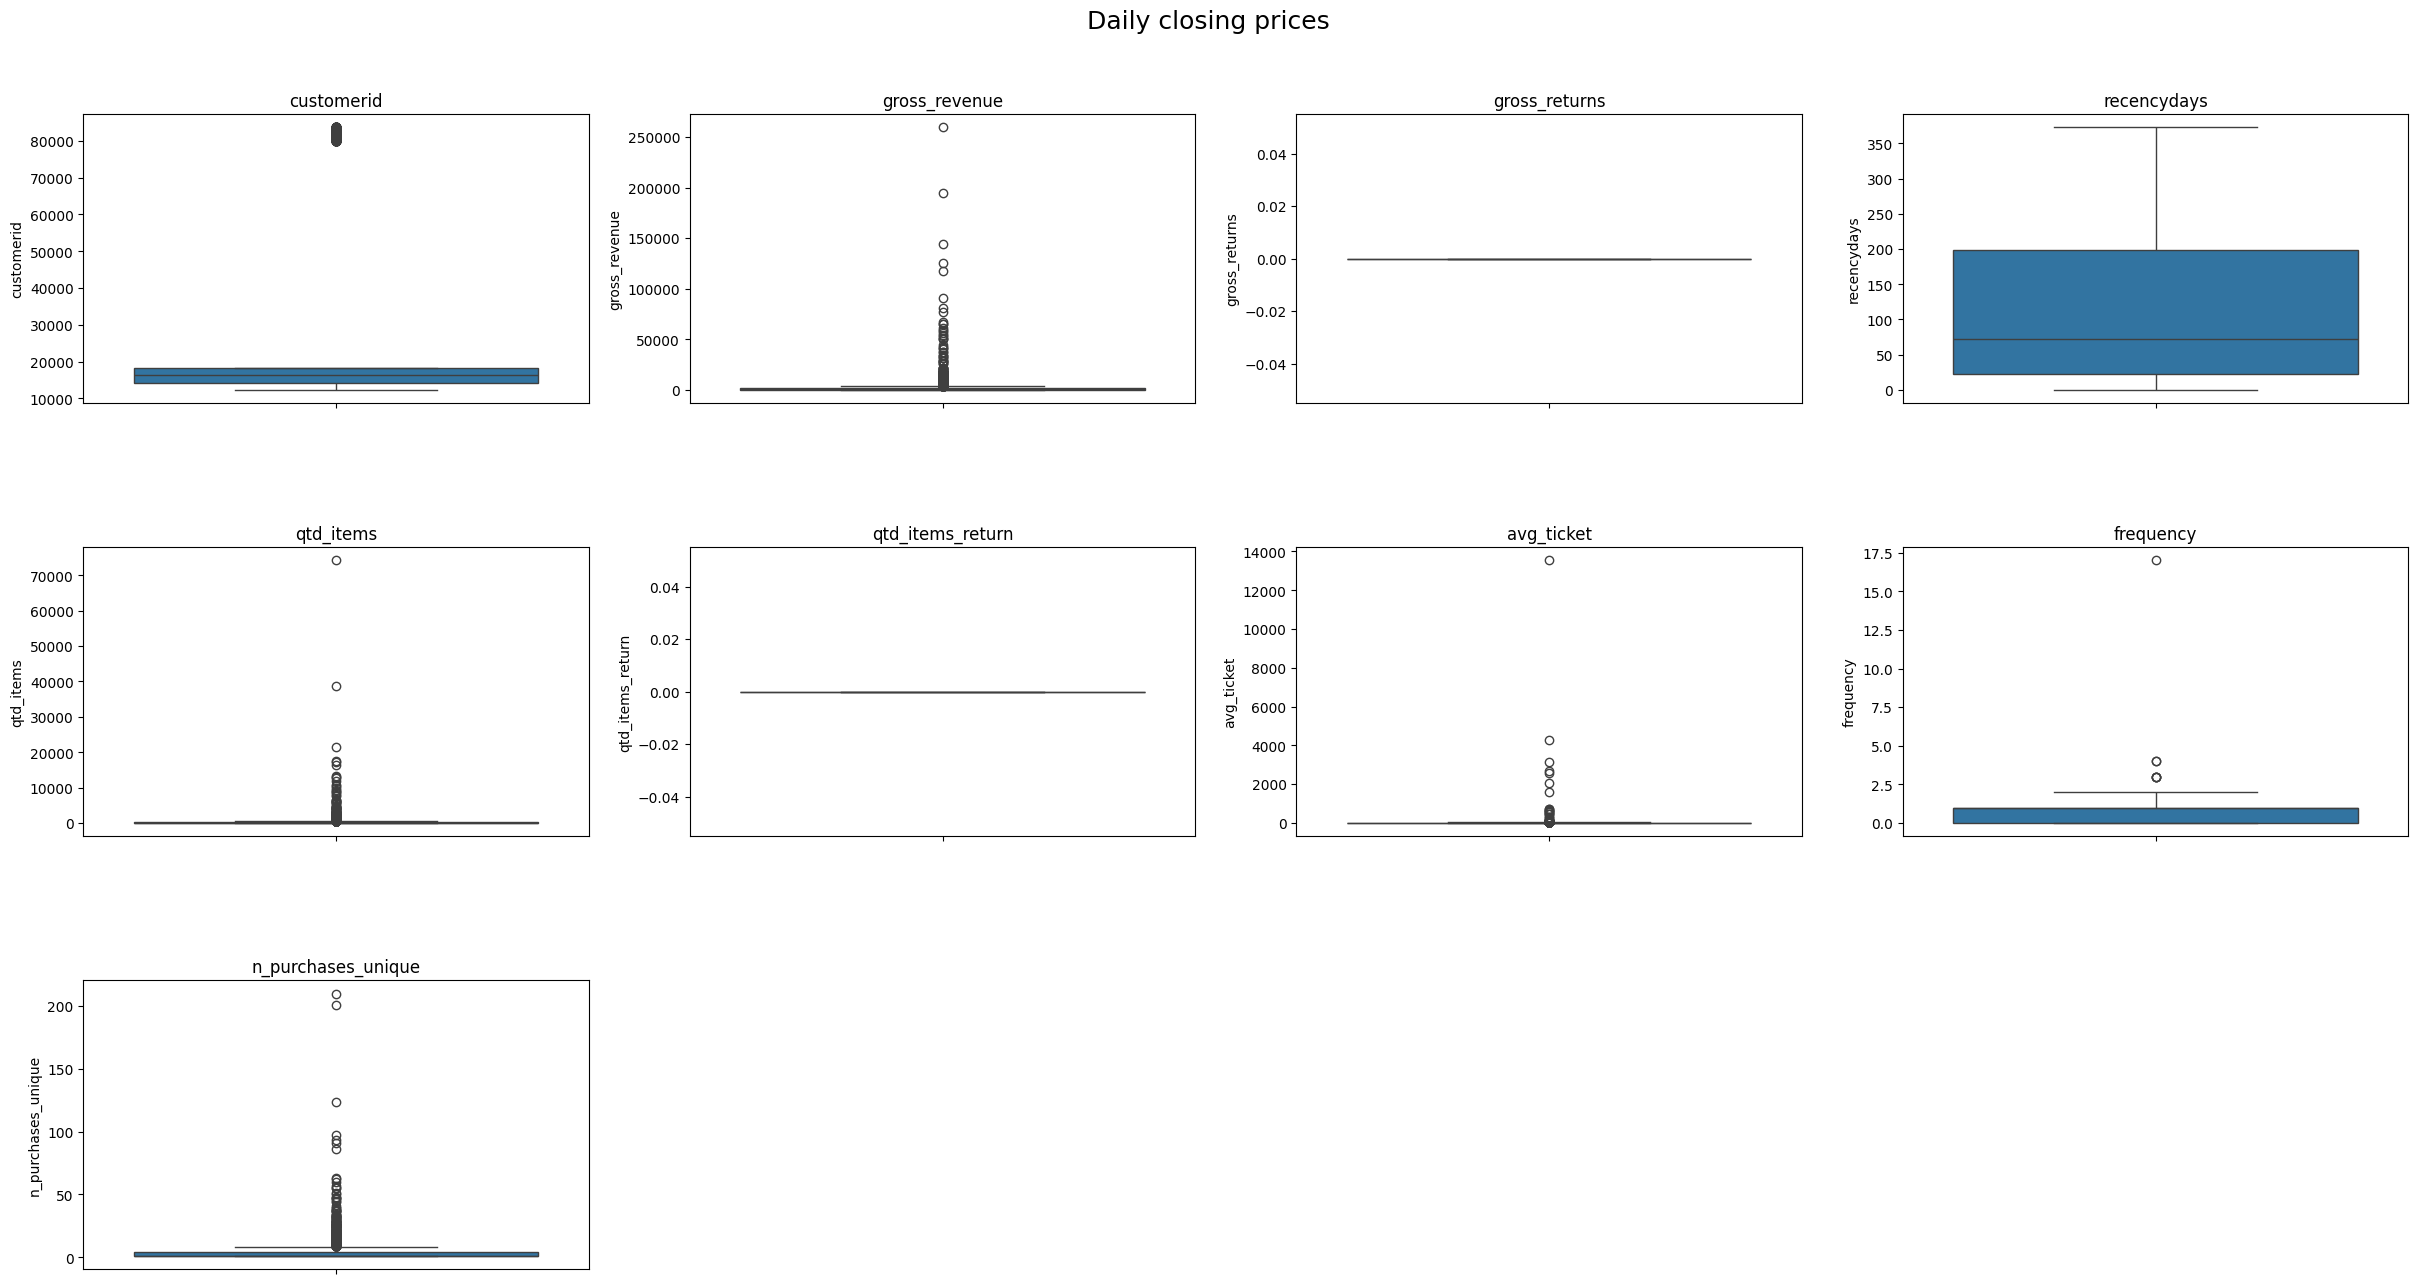

In [84]:
plt.figure(figsize=(30, 15));
plt.subplots_adjust(hspace=0.5);
plt.suptitle("Daily closing prices", fontsize=18, y=0.95);

tickers = df5.select_dtypes(exclude='object').columns;


# loop through the length of tickers and keep track of index
for n, ticker in enumerate(tickers):
    # add a new subplot iteratively
    ax = plt.subplot(3, 4, n + 1)

    sns.boxplot(data=df6[ticker])

    ax.set_title(ticker)


In [90]:
mms = MinMaxScaler()


mms_cols = ['recencydays','avg_ticket', 'frequency','gross_revenue', 'gross_returns','qtd_items_return']

for i in mms_cols:
     df6[[i]] = mms.fit_transform(df6[[i]])
     pickle.dump(mms, open(f"src/rescalers/{i}_minmax.pkl",'wb'))


rs = RobustScaler()

robust_cols = ['gross_returns', 'qtd_items', "n_purchases_unique"]

for i in robust_cols:
     df6[[i]] = rs.fit_transform(df6[[i]])
     pickle.dump(rs, open(f"src/rescalers/{i}_robust.pkl",'wb'))


df6.head()

,customerid,gross_revenue,gross_returns,recencydays,qtd_items,qtd_items_return,avg_ticket,frequency,n_purchases_unique
0,17850,0.020761,0.0,0.997319,-0.367470,0.0,0.011371,1.000000,11.000000
1,13047,0.012467,0.0,0.083110,0.216867,0.0,0.001807,0.001395,3.000000
2,12583,0.028041,0.0,0.005362,8.873494,0.0,0.000338,0.002052,4.666667
3,13748,0.003650,0.0,0.254692,0.439759,0.0,0.000410,0.000734,1.333333
4,15100,0.003372,0.0,0.892761,-0.289157,0.0,0.001343,0.003985,0.666667


# 7.0 Hyperparameter Tuning

In [91]:
df7=df6.copy()
X=df7.drop(columns=['customerid'])
clusters= [2, 3, 4, 5,6, 7, 8]

In [92]:
X.head(1)

,gross_revenue,gross_returns,recencydays,qtd_items,qtd_items_return,avg_ticket,frequency,n_purchases_unique
0,0.020761,0.0,0.997319,-0.36747,0.0,0.011371,1.0,11.0


## 7.1 KMeans


[0.395417540683613,
 0.40804516059046414,
 0.40915122611204924,
 0.4295877999201504,
 0.42680763578998265,
 0.43743020530669846,
 0.4291116441222676]

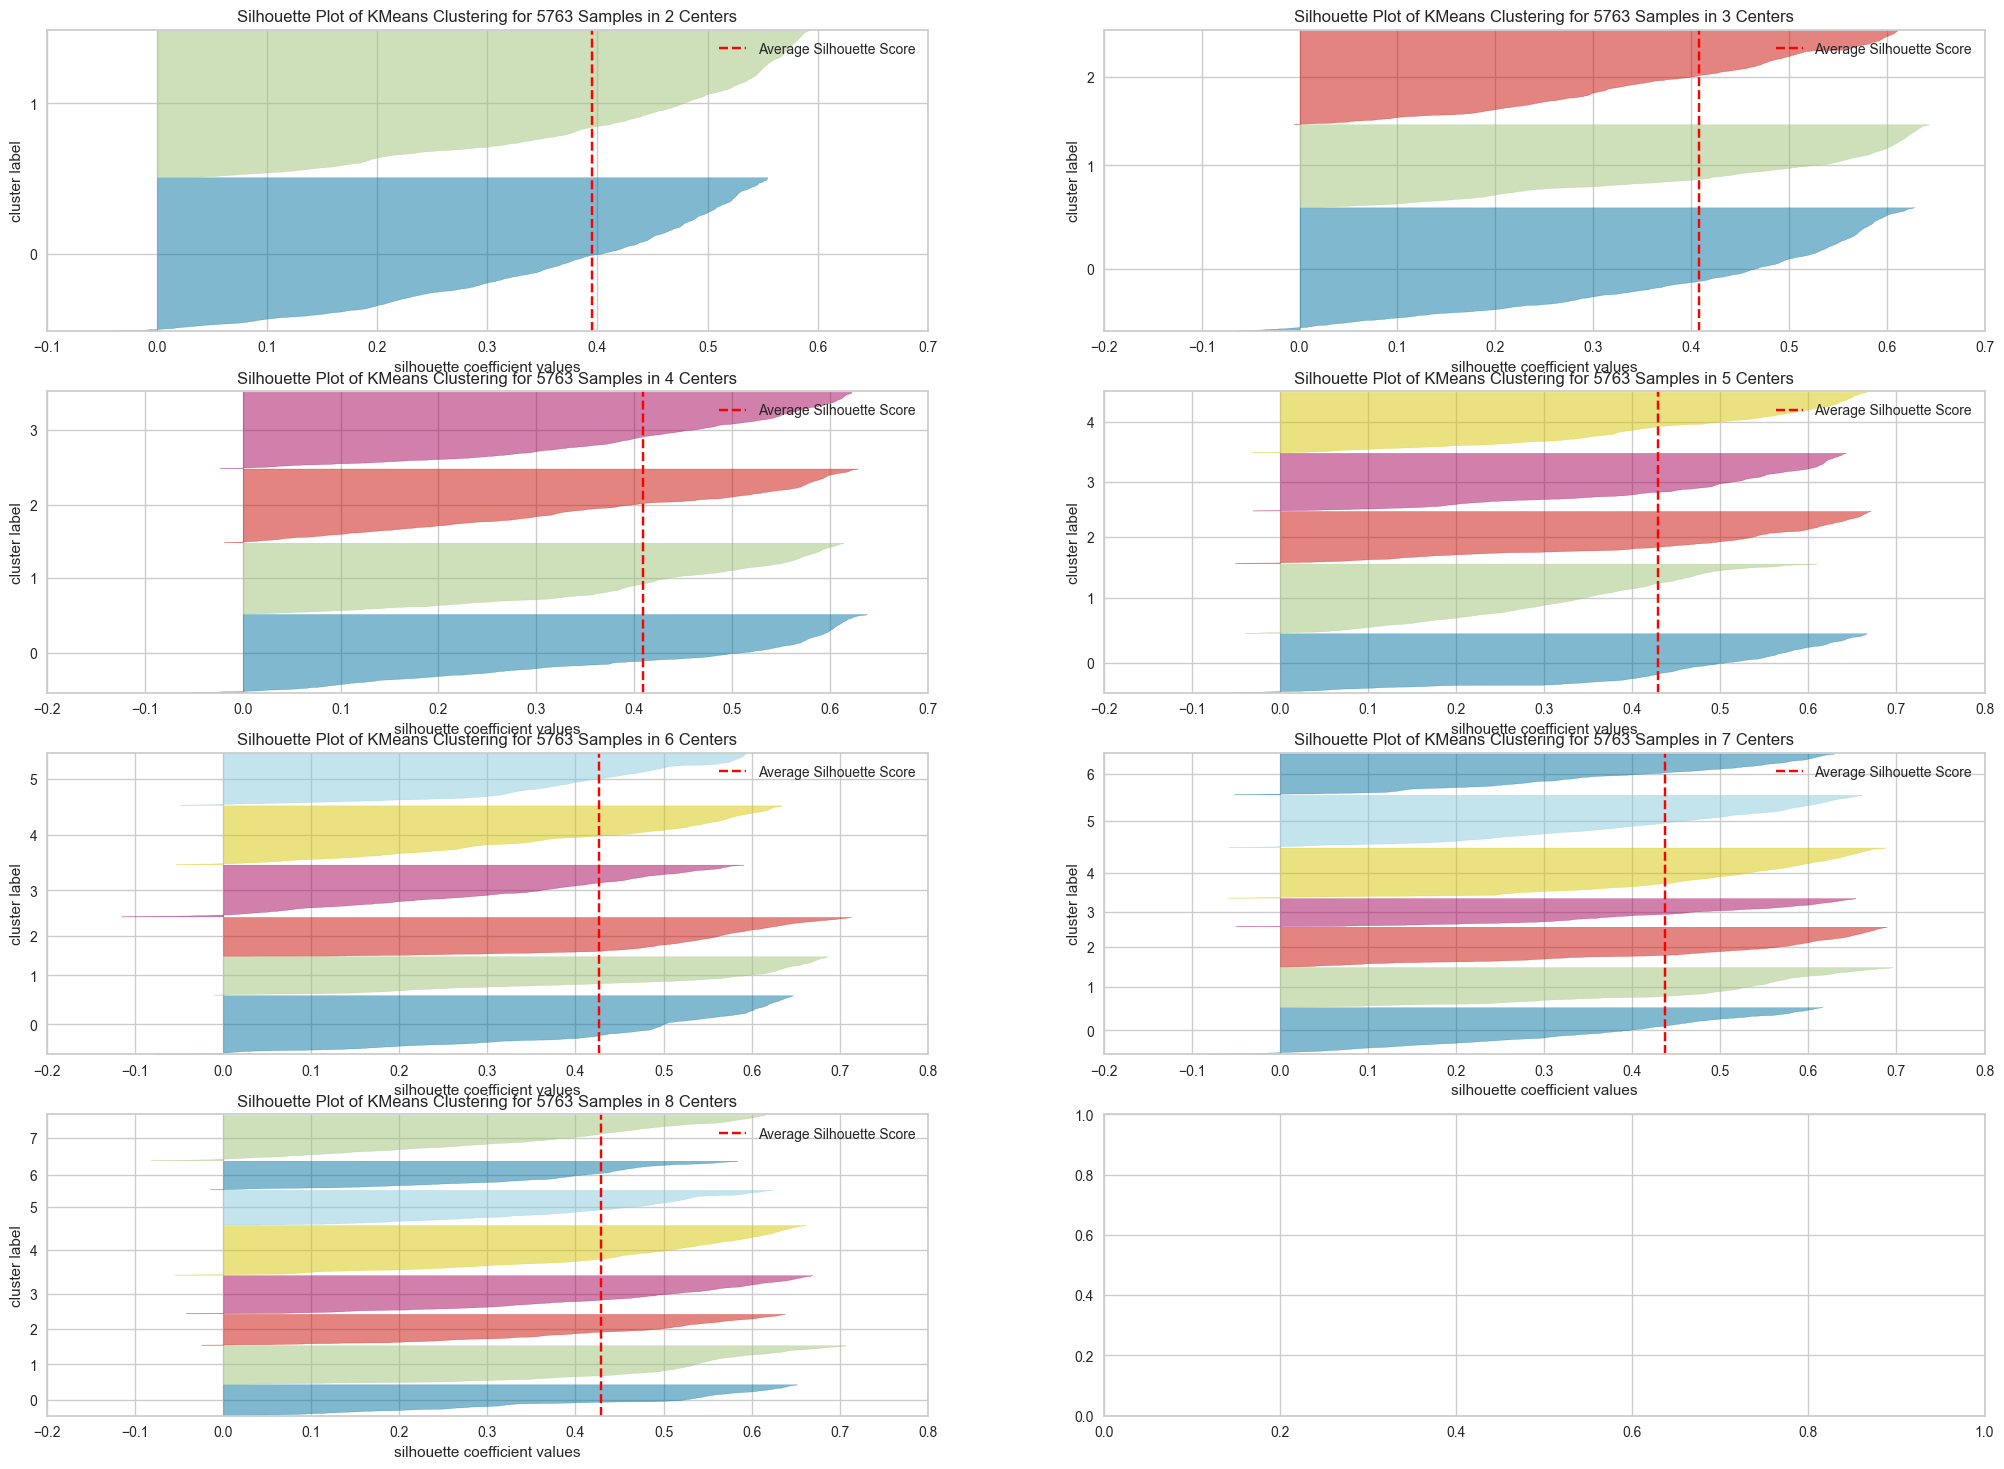

In [151]:
fig, ax = plt.subplots( 4, 2, figsize=(25, 18))

kmeans_list = []
for k in clusters:
    km = c.KMeans(n_clusters=k, init="k-means++", n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(k, 2)
    vis_silhouette = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    vis_silhouette.fit(X)
    vis_silhouette.finalize()
    kmeans_list.append(vis_silhouette.silhouette_score_)
kmeans_list

## 7.2 GMM

In [153]:
gmm_list = []
for k in clusters:
    # model definition
    gmm_model = GaussianMixture( n_components=k )

    # model training
    gmm_model.fit( X )

    # model predict
    labels = gmm_model.predict( X )

    # model performance
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    gmm_list.append( sil )
gmm_list

[0.39145727815610265,
 0.3598103002074093,
 0.20970114993074146,
 0.26277053944154577,
 0.29205931133278057,
 0.23004767162687162,
 0.2721315904007406]

Text(0.5, 1.0, 'Sil x K')

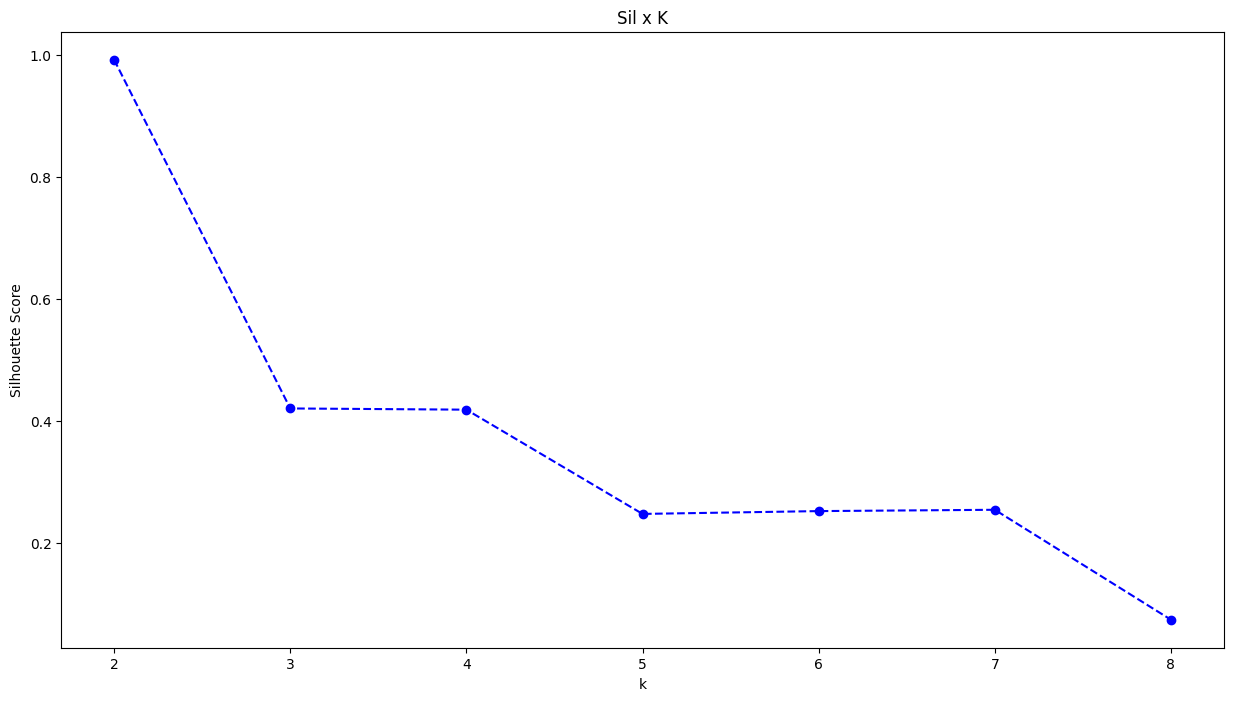

In [96]:
plt.plot( clusters, gmm_list, linestyle='--', marker='o', color='b' )
plt.xlabel( 'k')
plt.ylabel( 'Silhouette Score')
plt.title( 'Sil x K')

## 7.3 Hierarchical Clustering

[]

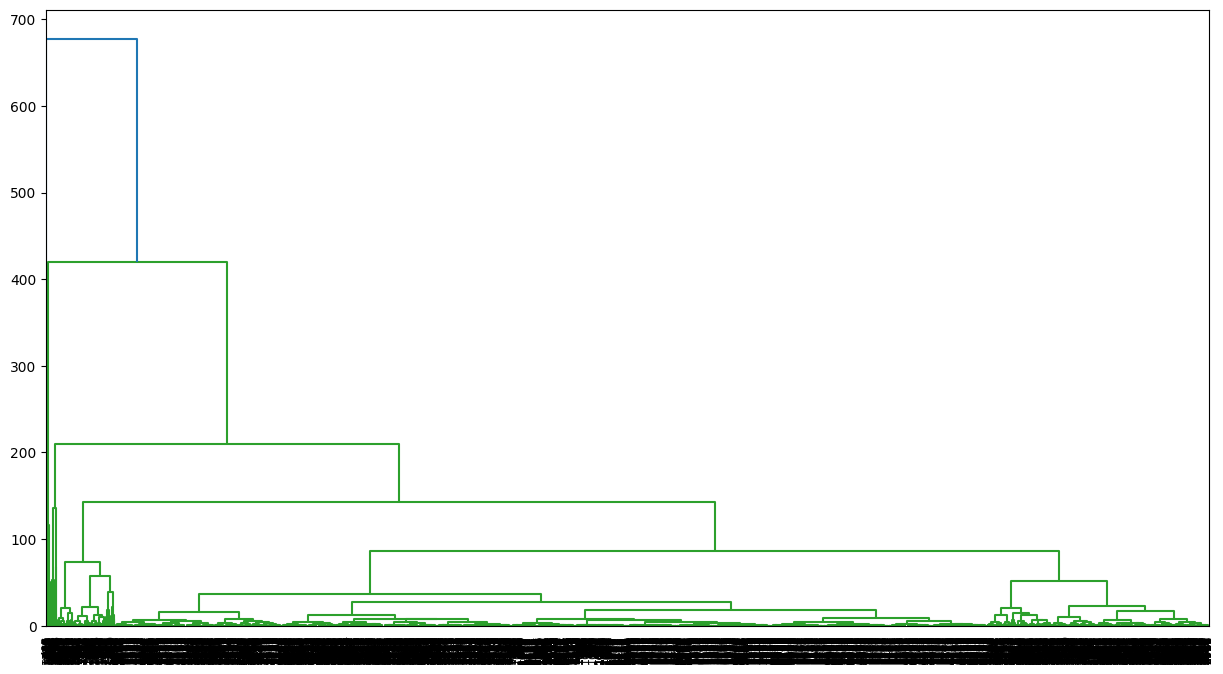

In [98]:
hc_model = hc.linkage( X, 'ward' )
hc.dendrogram( 
    hc_model, 
    leaf_rotation=90,
    leaf_font_size=8
)
plt.plot()

In [154]:
hc_list = []
for k in clusters:
    # model definition & training
    hc_model = hc.linkage( X, 'ward' )

    # model predict
    labels = hc.fcluster( hc_model, k, criterion='maxclust' ) 

    # metrics
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    hc_list.append( sil )
hc_list

[0.3823770998497696,
 0.38320716374839947,
 0.3806103459905302,
 0.43004717414163335,
 0.425108026777084,
 0.4150573323185762,
 0.38241559864585684]

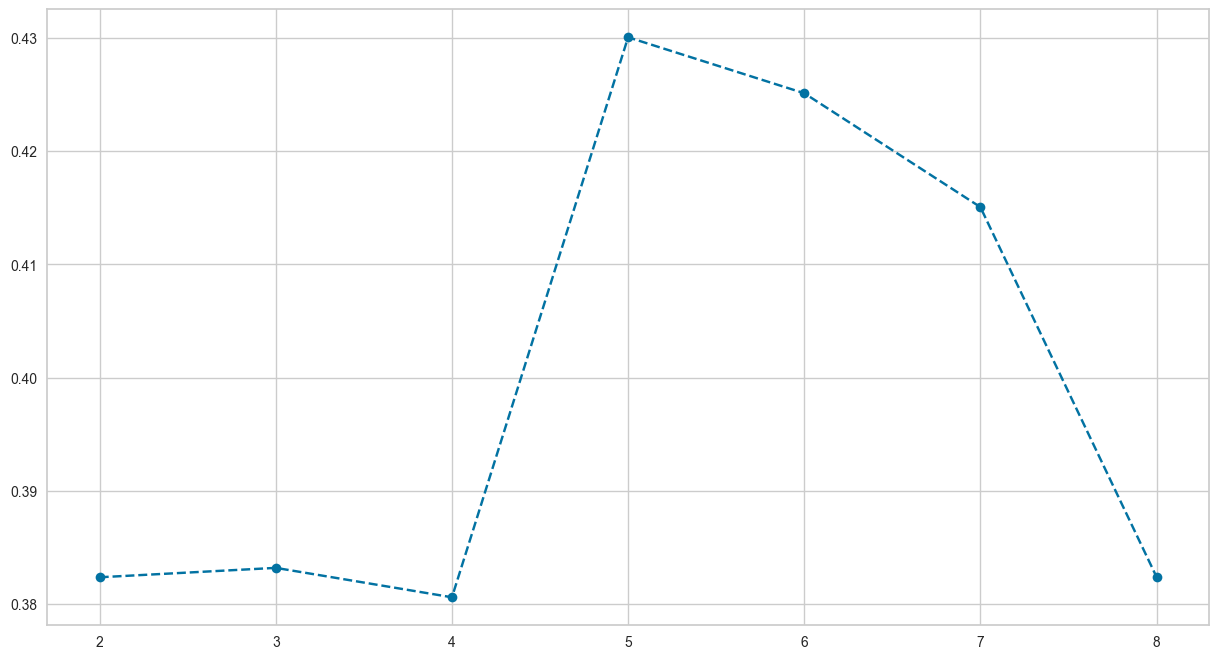

In [155]:
plt.plot( clusters,  hc_list, linestyle='--', marker='o', color='b' ) 

## 7.5 PCA reducer

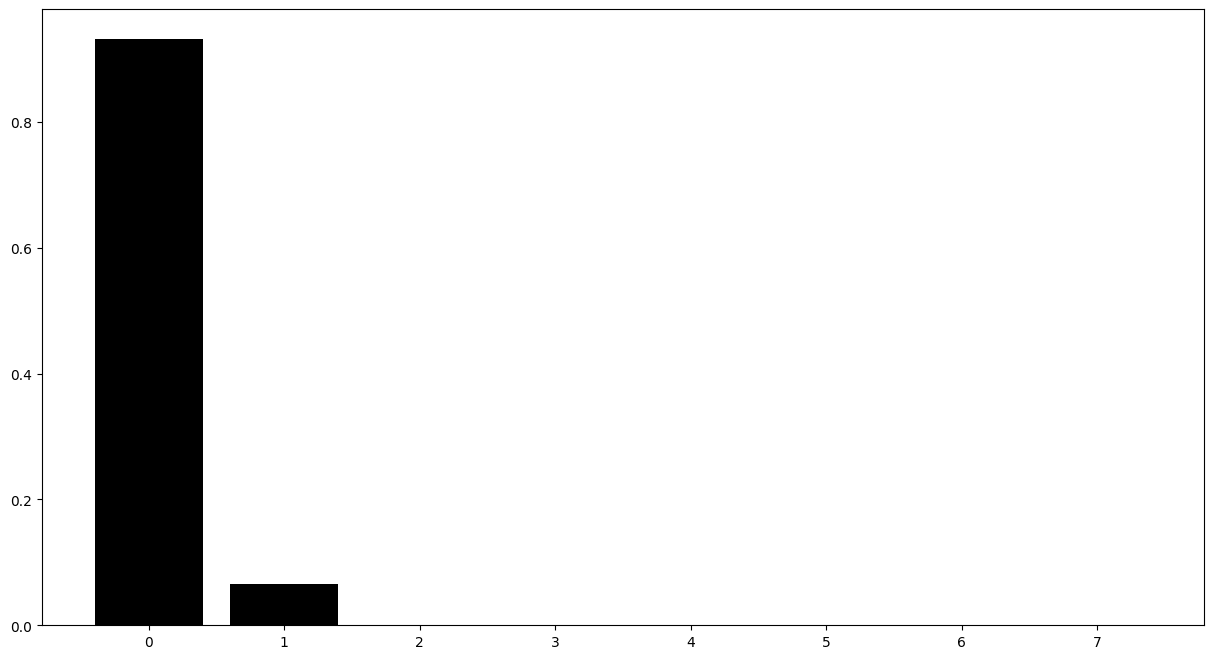

In [102]:
pca = PCA(n_components=X.shape[1])

principal_components = pca.fit_transform(X)

features = range( pca.n_components_)

plt.bar( features, pca.explained_variance_ratio_, color='black')

df_pca=pd.DataFrame(principal_components)

<Axes: xlabel='0', ylabel='1'>

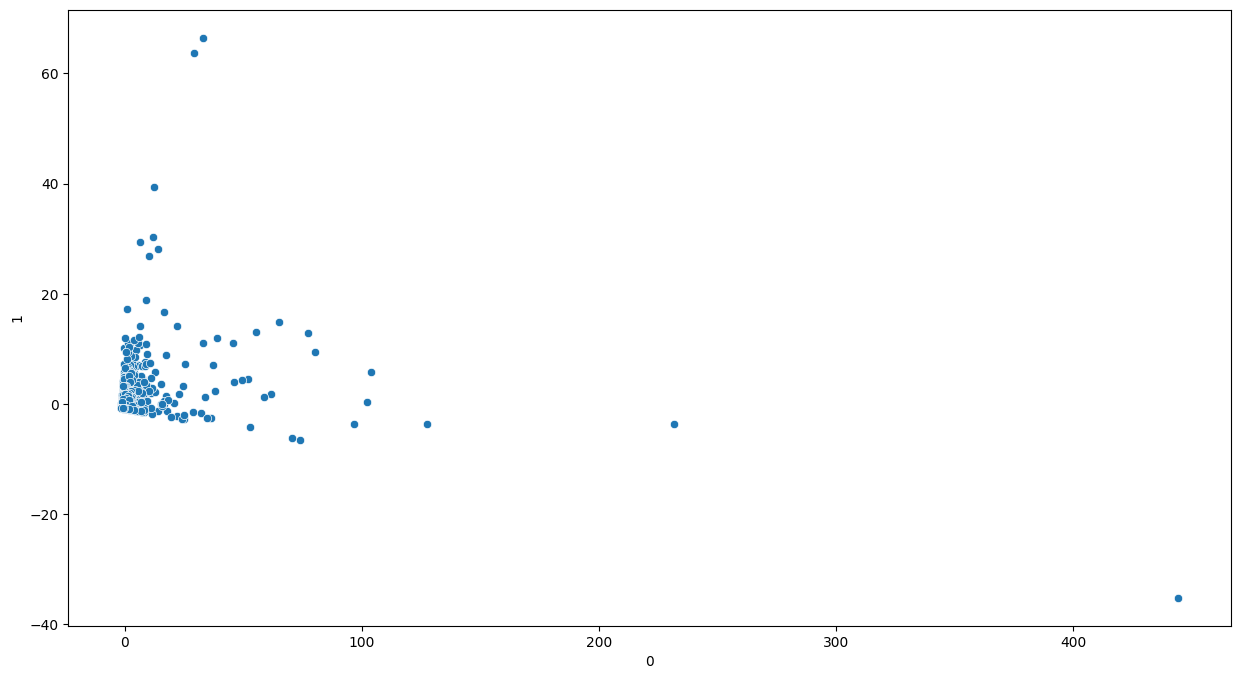

In [103]:
sns.scatterplot(x=0 , y=1, data=df_pca)

In [ ]:
#PCA couldn't separate well the datapoints, for clustering problems, it's good to have the data separate in groups as much as possible.

## 7.6 TSNE Reducer

<Axes: xlabel='embedding_x', ylabel='embedding_y'>

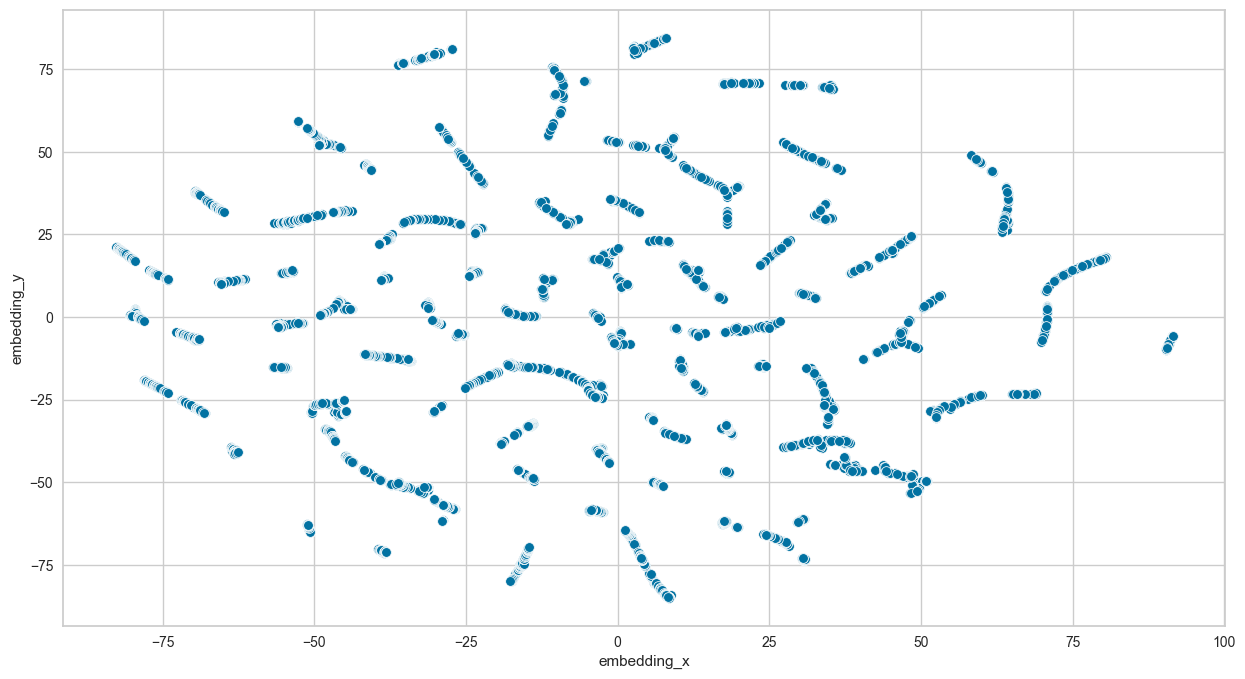

In [162]:
reducer = TSNE(n_components=2, random_state=42)
embedding = reducer.fit_transform( X )

# embedding
X['embedding_x']=embedding[:,0]
X['embedding_y']=embedding[:,1]

X_TSNE = pd.concat([X['embedding_x'], X["embedding_y"]], axis=1)

# plot UMAP
sns.scatterplot(x='embedding_x',y='embedding_y', data=X)

In [ ]:
#TSNE performed better than PCA, we can see some groups formed by the embedding, let's find out if a KMeans algorithm cam create good clusters with this embedding.

[0.34102377,
 0.36698276,
 0.36719224,
 0.34209707,
 0.37605366,
 0.38286403,
 0.36727723]

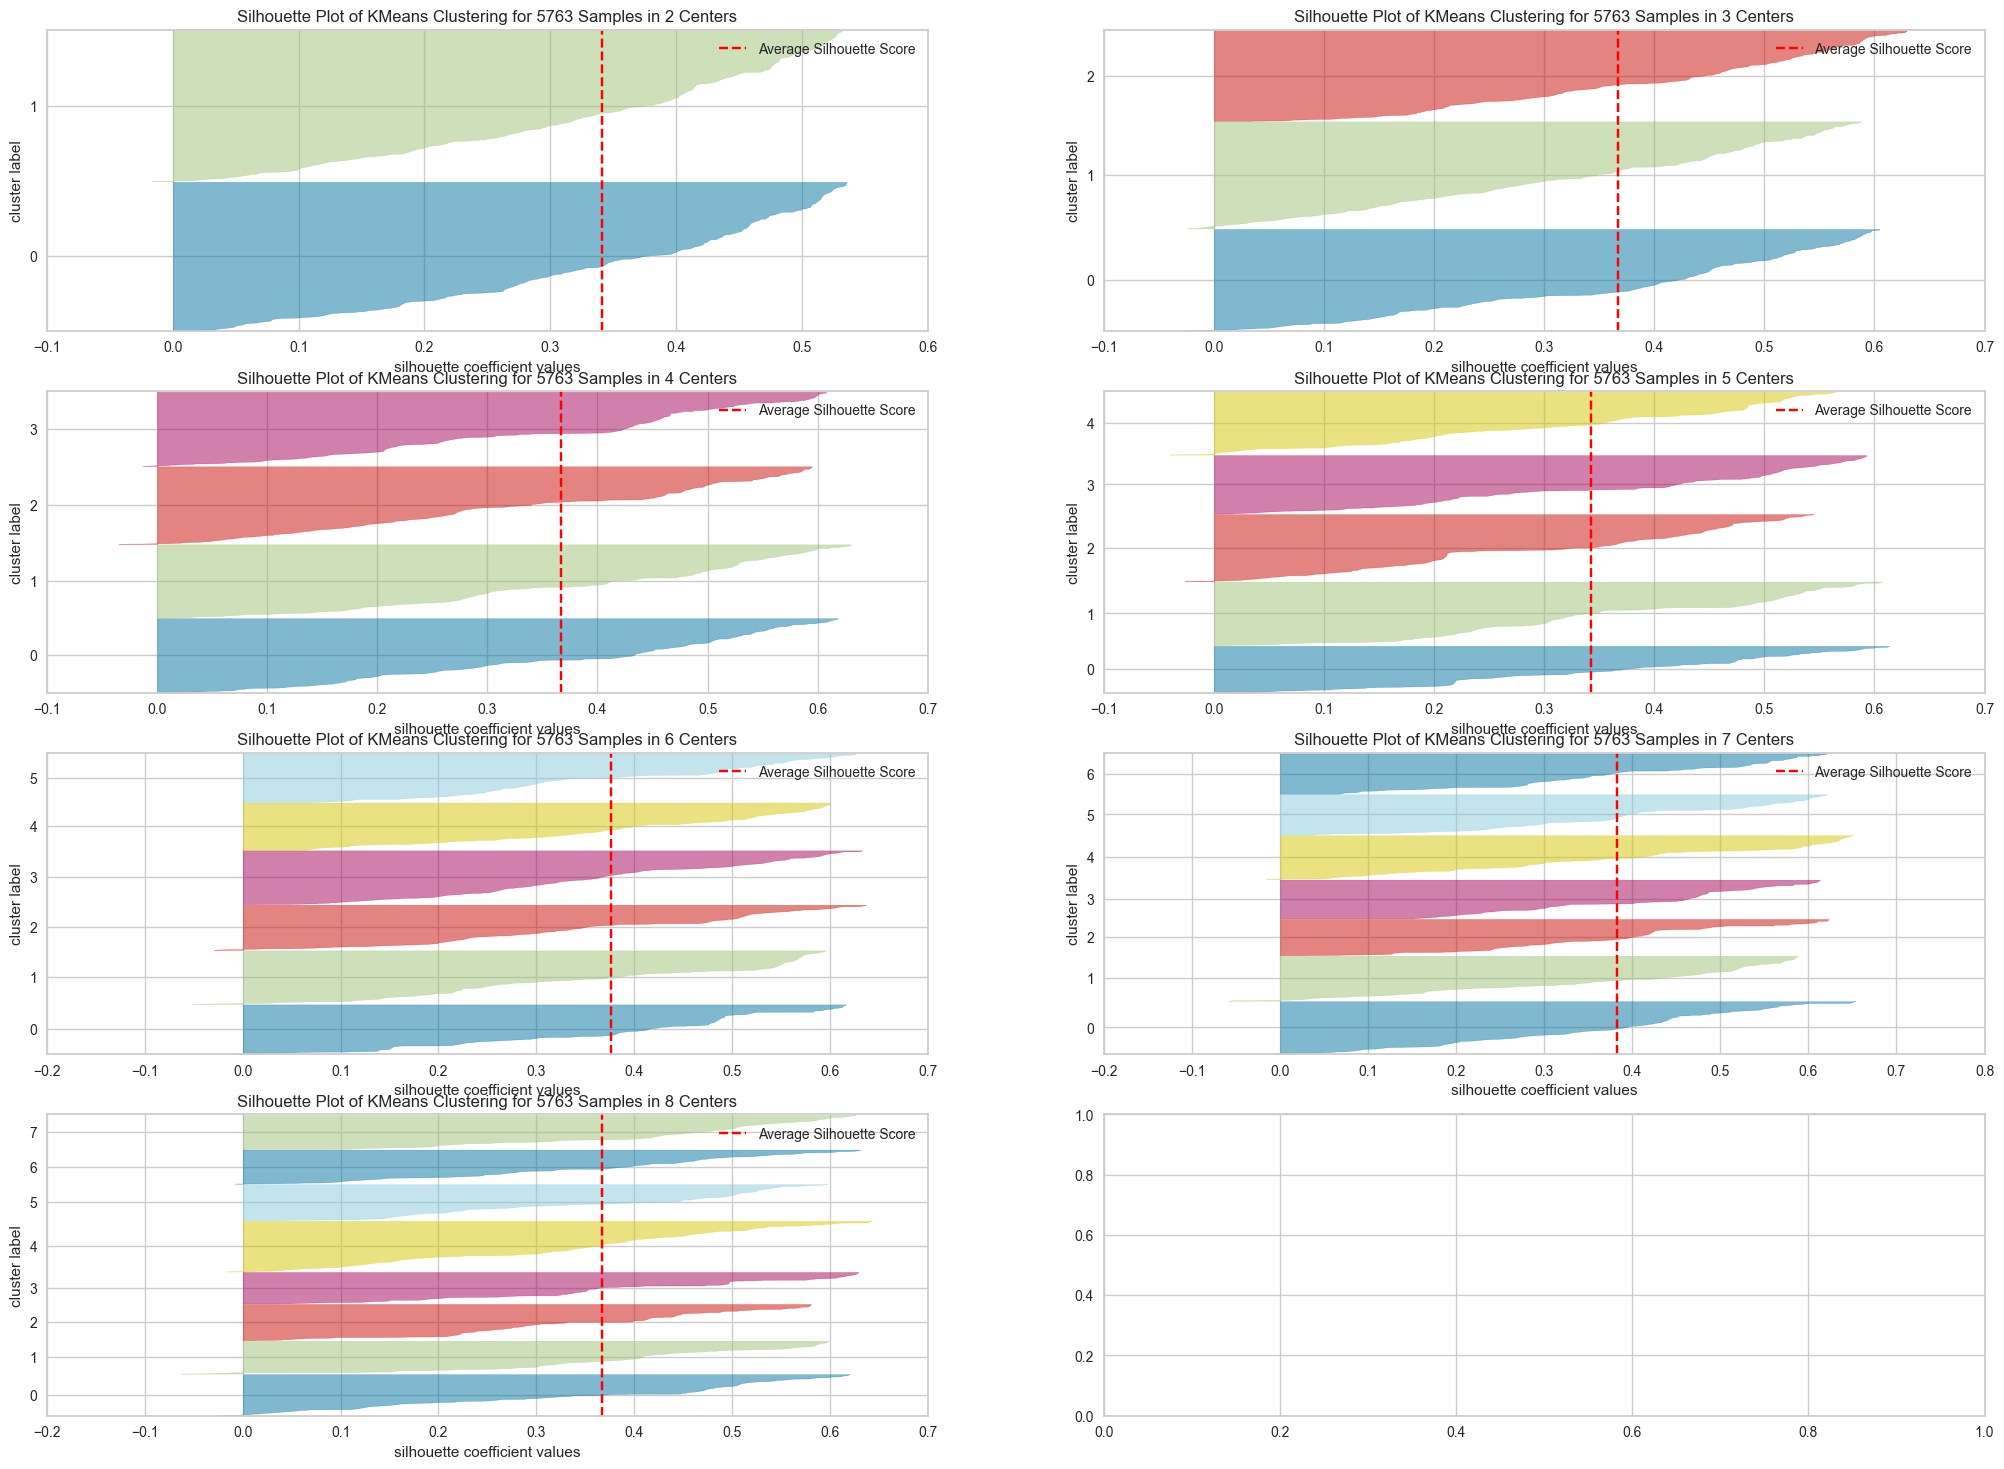

In [166]:
fig, ax = plt.subplots( 4, 2, figsize=(25, 18))

TSNE_KMeans=[]
for k in clusters:
    km = c.KMeans(n_clusters=k, init="k-means++", n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(k, 2)
    vis_silhouette_tsne = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    vis_silhouette_tsne.fit(X_TSNE)
    vis_silhouette_tsne.finalize()
    TSNE_KMeans.append(vis_silhouette_tsne.silhouette_score_)
TSNE_KMeans

In [167]:
np.max(TSNE_KMeans)

0.38286403

In [ ]:
#The highest silhouette score was of 0.38

## 7.7 UMAP Reducer

p:\Python\GitHub\inside_repo\dev_env\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
C:\Users\kosmo\AppData\Local\Temp\ipykernel_8284\3009470392.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x='embedding_x',y='embedding_y',


<Axes: xlabel='embedding_x', ylabel='embedding_y'>

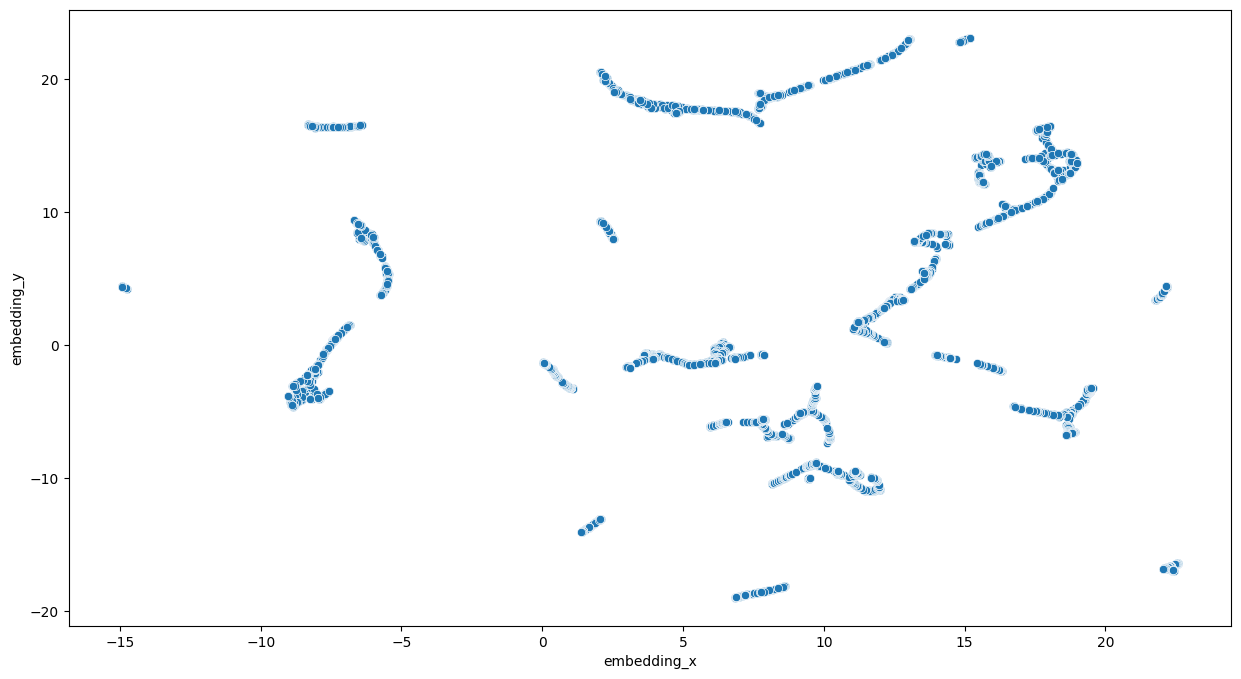

In [105]:
df_umap=X.copy()

reducer = umap.UMAP(n_neighbors=300, random_state=42)
embedding_umap = reducer.fit_transform( X )

# # embedding
df_umap['embedding_x']=embedding_umap[:,0]
df_umap['embedding_y']=embedding_umap[:,1]

# plot UMAP
sns.scatterplot(x='embedding_x',y='embedding_y',
                palette=sns.color_palette('hls'),
                data=df_umap)

In [ ]:
# UMAP created a good separation and groups among in the data points, let's find out if a algorith can create good clusters with it :)

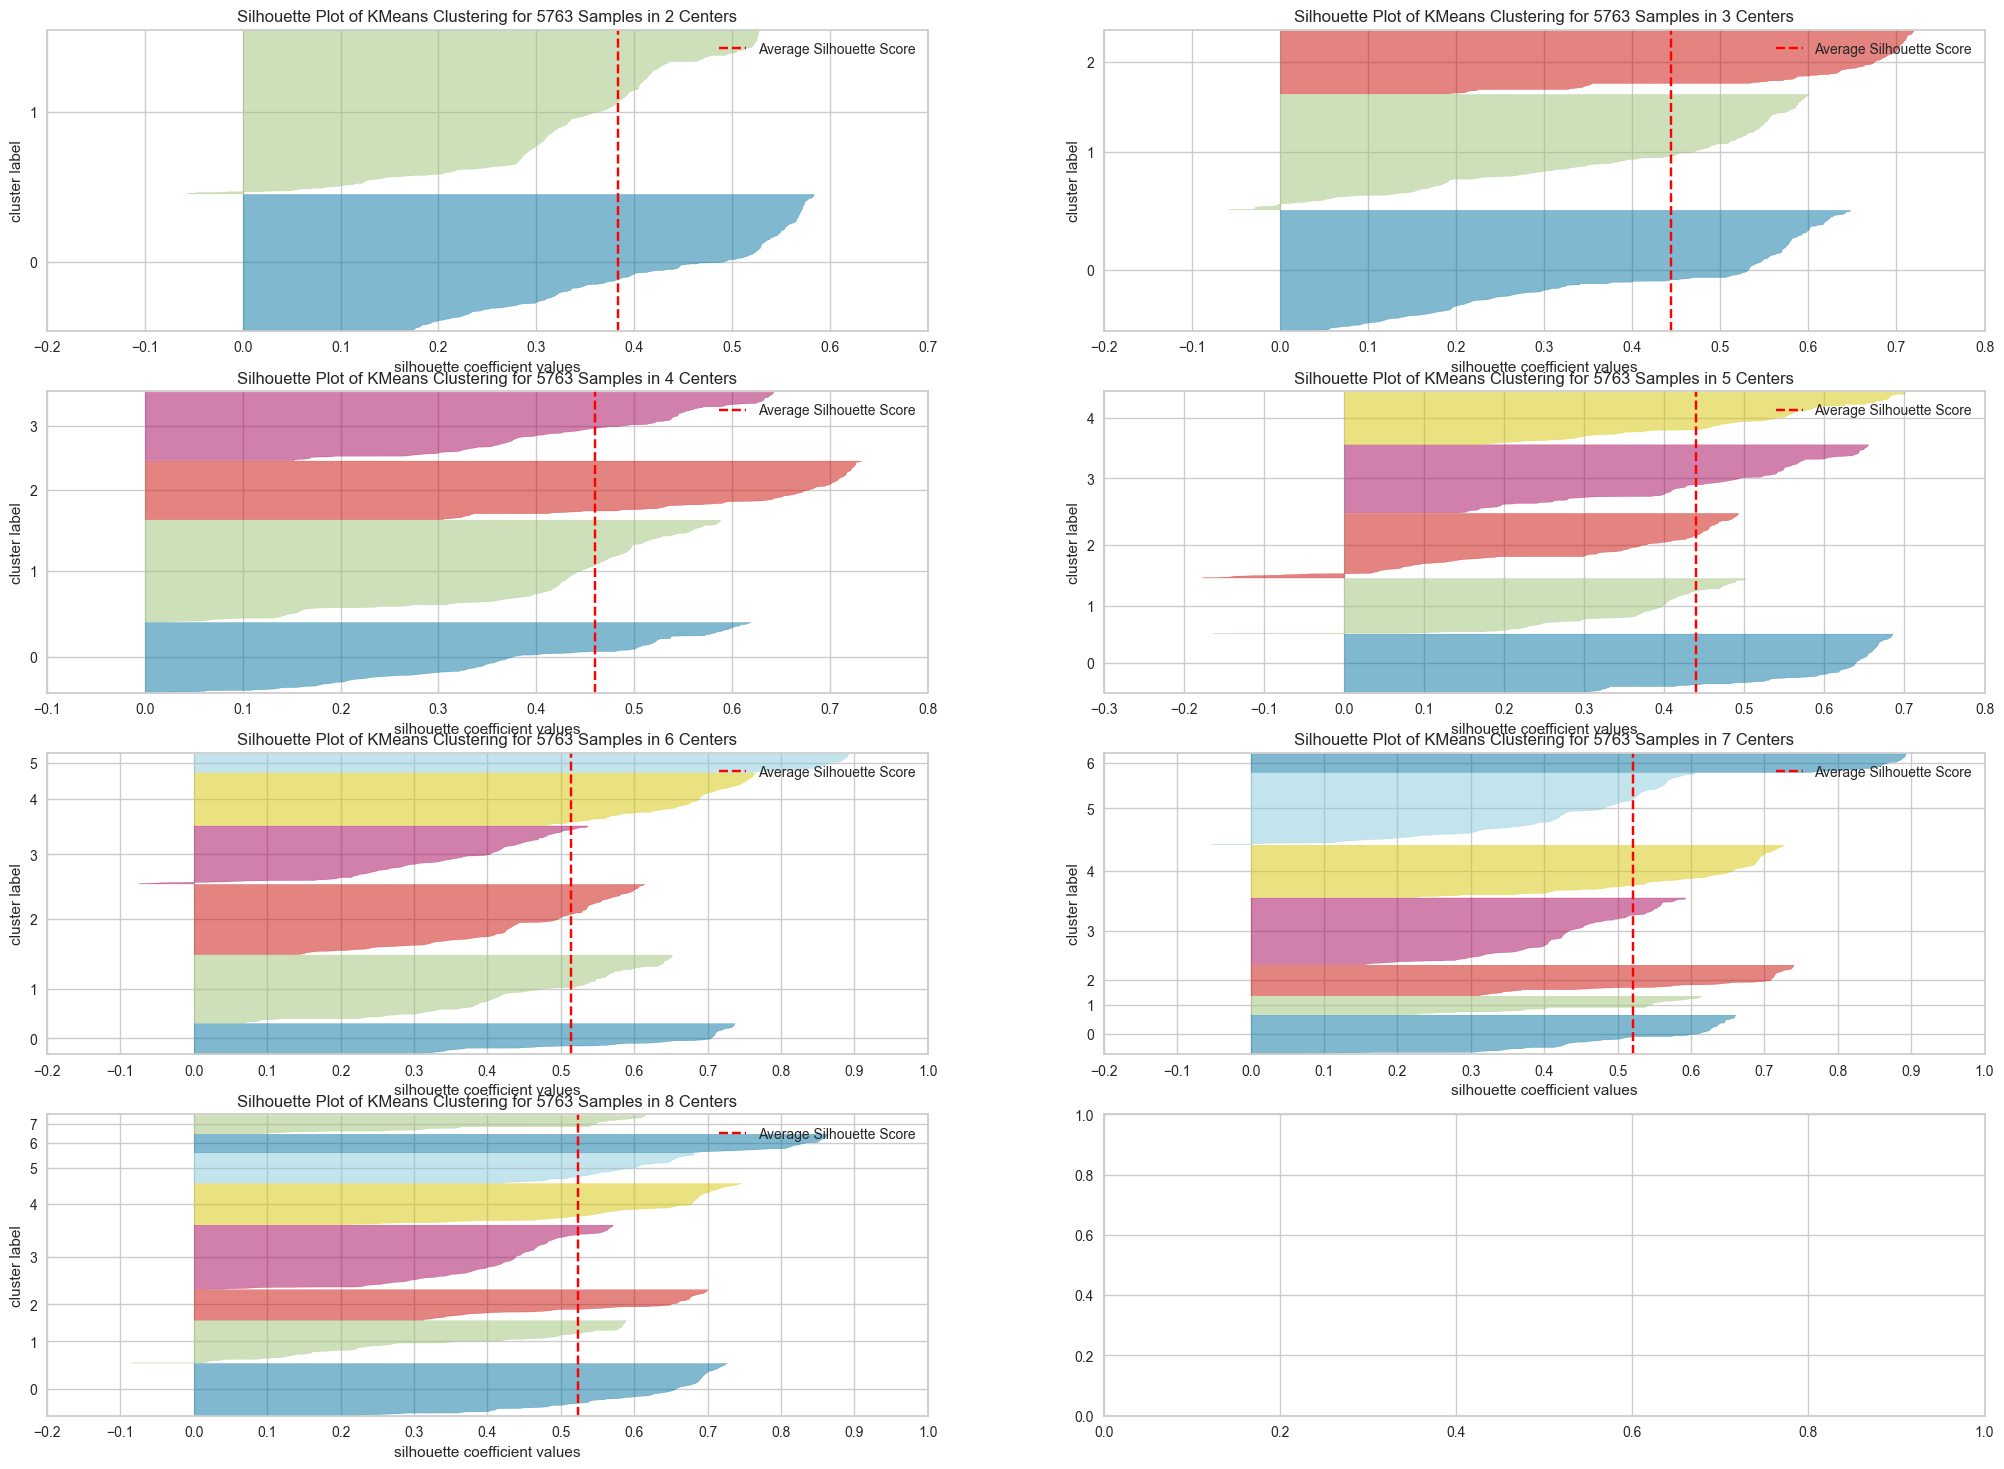

In [168]:
clusters=[2, 3, 4, 5, 6, 7, 8]

fig, ax = plt.subplots( 4, 2, figsize=(25, 18))

for k in clusters:
    km = c.KMeans(n_clusters=k, init="k-means++", n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(k, 2)
    vis_silhouette_umap = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    vis_silhouette_umap.fit(embedding_umap)
    vis_silhouette_umap.finalize()

In [172]:
print(f"the highest silhouette score of a KMeans trained in a umap reduced data was: ",np.max(vis_silhouette_umap.silhouette_score_))

the highest silhouette score of a KMeans trained in a umap reduced data was:  0.5236485


## 7.7 Tree Based Embedding

In [111]:
# training dataset

a1 = X.drop(['gross_revenue'],axis=1)
y = X['gross_revenue']


# model definition
rf_model = RandomForestRegressor( n_estimators=100, random_state=42)

# model training

rf_model.fit( a1, y )

#leaf 

df_leaf = pd.DataFrame(rf_model.apply(a1))
a1.head(2)

,gross_returns,recencydays,qtd_items,qtd_items_return,avg_ticket,frequency,n_purchases_unique,embedding_x,embedding_y
0,0.0,0.997319,-0.367470,0.0,0.011371,1.000000,11.0,76.906837,1.852974
1,0.0,0.083110,0.216867,0.0,0.001807,0.001395,3.0,72.020470,31.916765


### 7.7.1 Tree Based Embedding + TSNE

<Axes: xlabel='embedding_x', ylabel='embedding_y'>

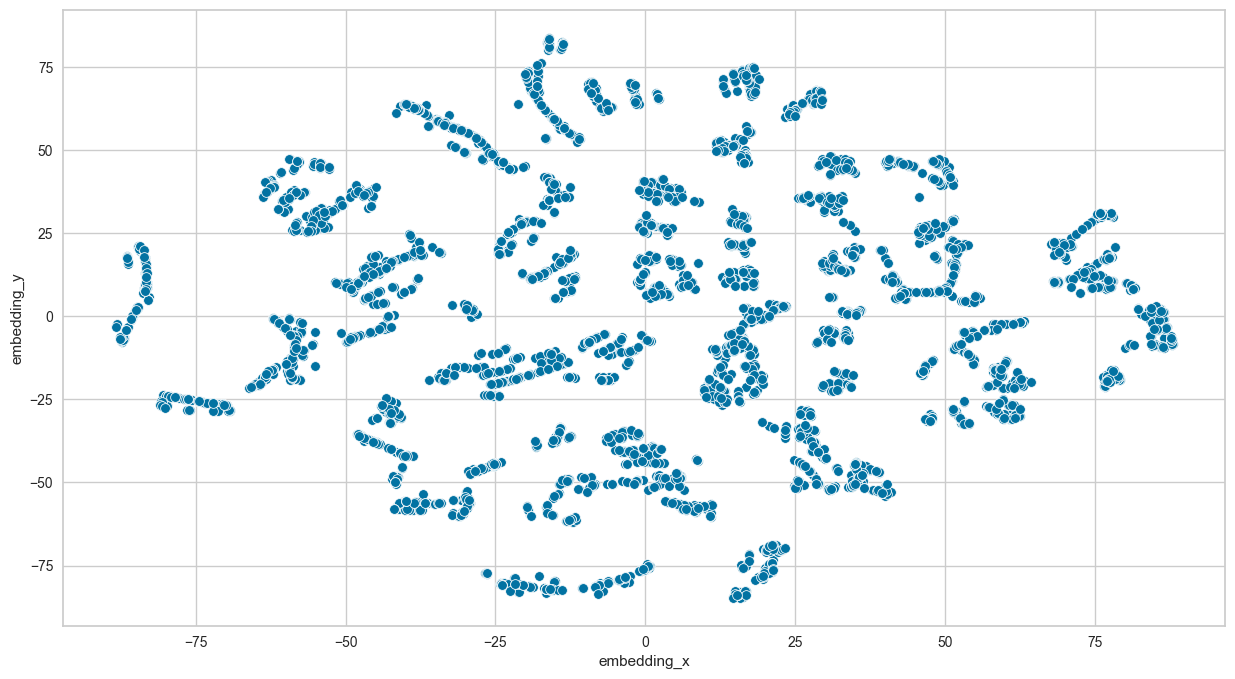

In [173]:
reducer = TSNE( random_state=42)

df_leaf_tsne = df_leaf.copy()

embedding_tree = reducer.fit_transform( df_leaf_tsne )


# embedding
df_leaf_tsne['embedding_x'] = embedding_tree[:,0]
df_leaf_tsne['embedding_y'] = embedding_tree[:,1]

df_tree_tsne = pd.concat([df_leaf_tsne["embedding_x"], df_leaf_tsne["embedding_y"]], axis=1)

# plot UMAP
sns.scatterplot(x='embedding_x',y='embedding_y',
                data=df_leaf_tsne)

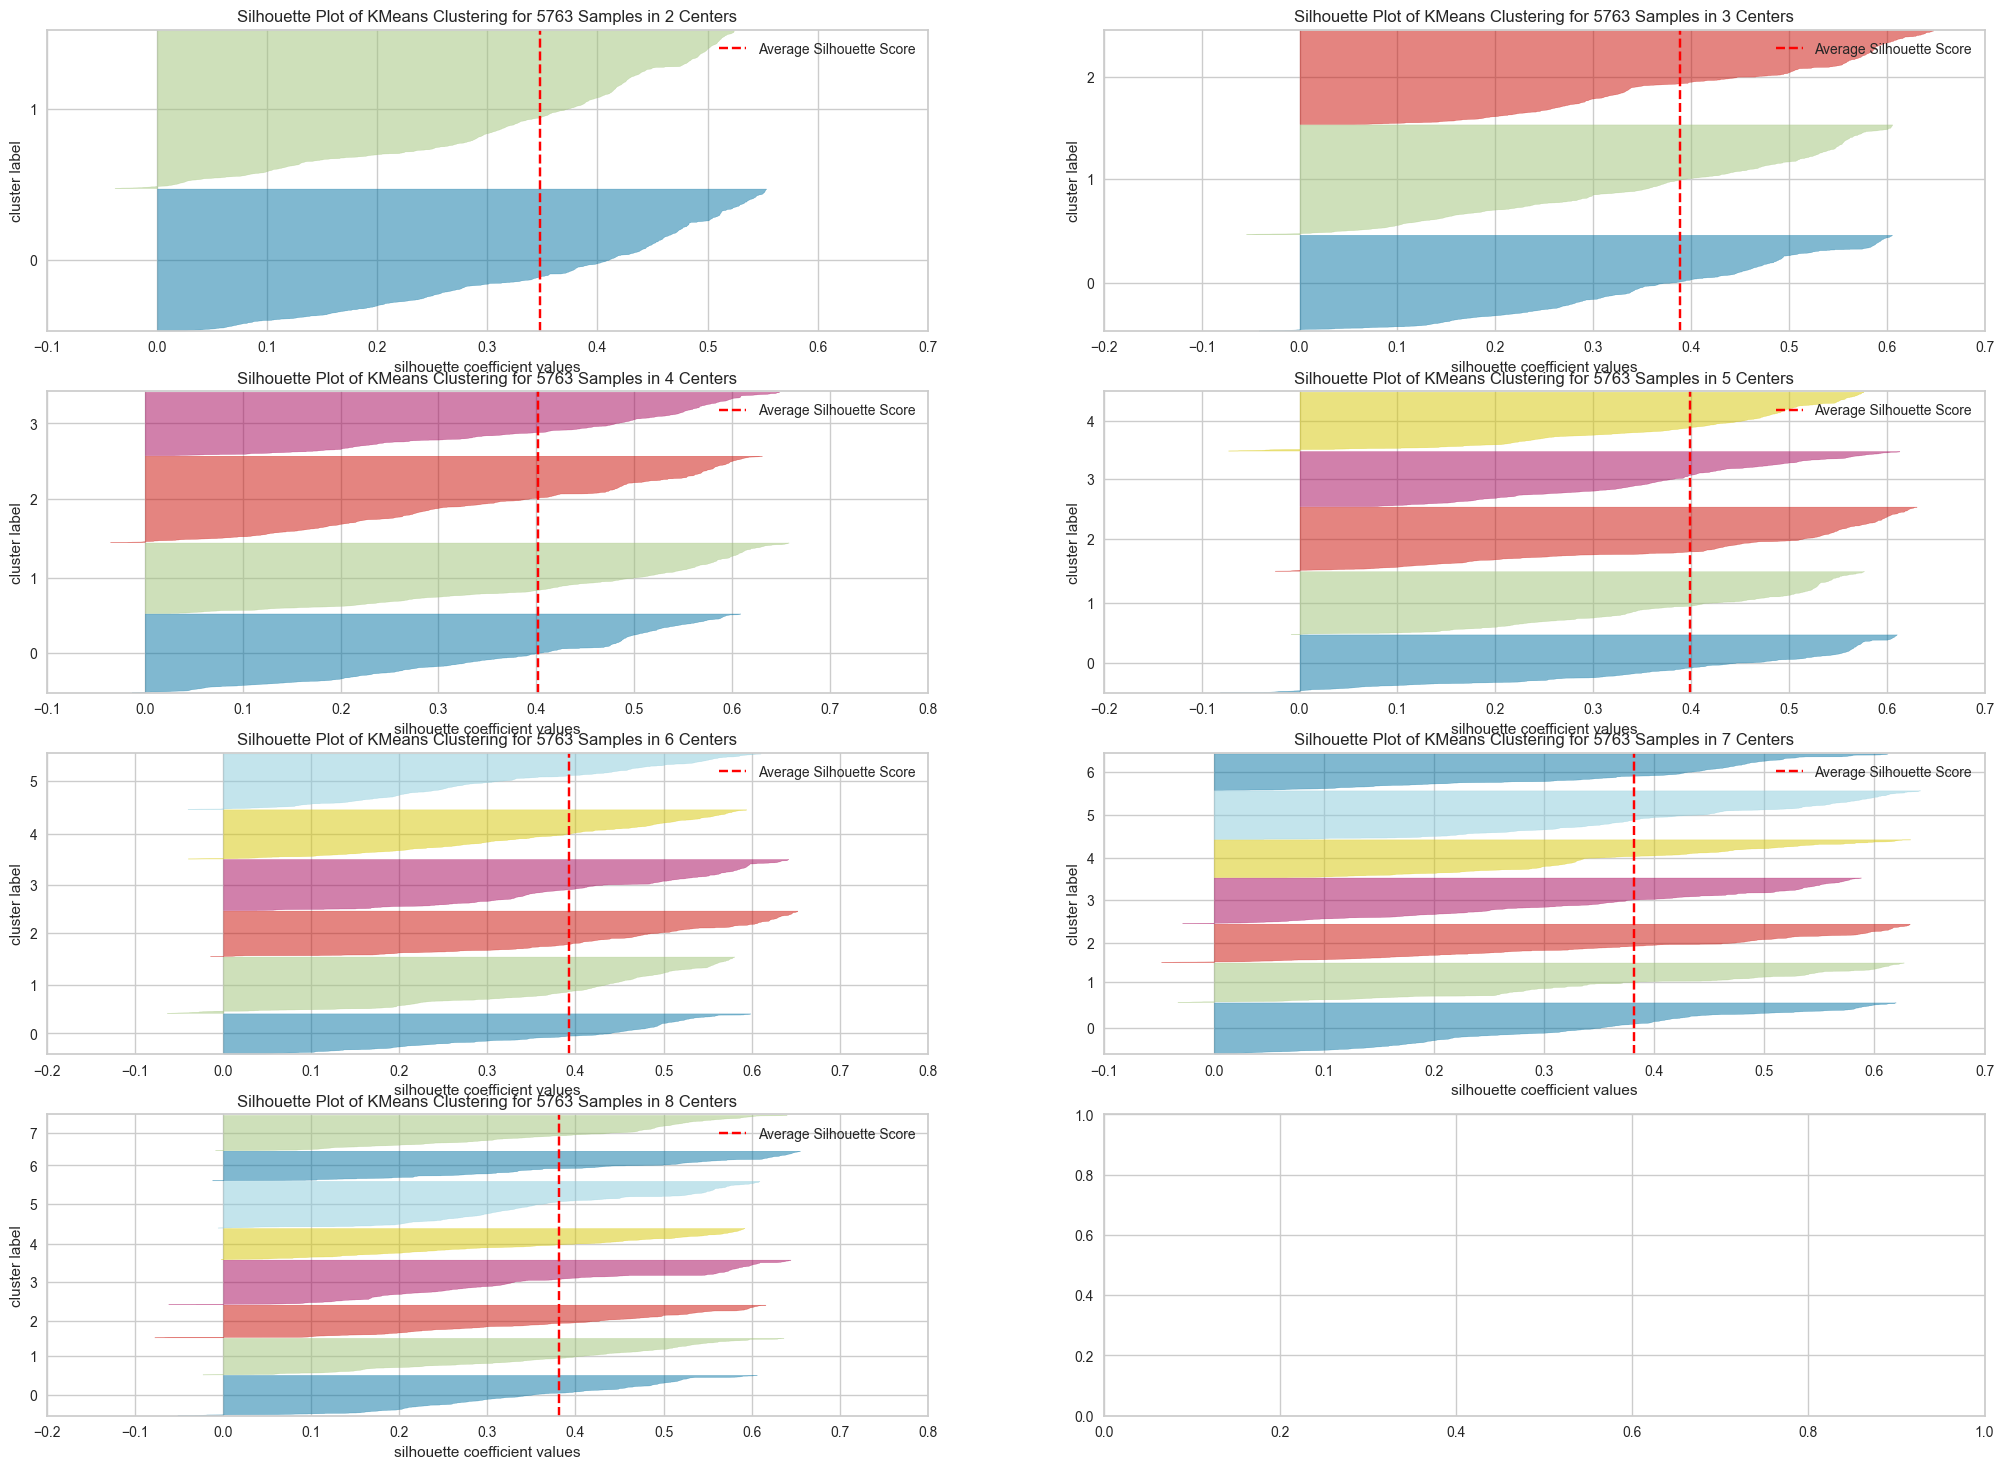

In [178]:
clusters=[2, 3, 4, 5, 6, 7, 8]

fig, ax = plt.subplots( 4, 2, figsize=(25, 18))

tree_tsne_scores = []

for k in clusters:
    km = c.KMeans(n_clusters=k, init="k-means++", n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(k, 2)
    vis_silhouette_tree_tsne = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    vis_silhouette_tree_tsne.fit(df_tree_tsne)
    vis_silhouette_tree_tsne.finalize()
    tree_tsne_scores.append(vis_silhouette_tsne.silhouette_score_)

In [179]:

print(f"the highest silhouette score of a KMeans trained in a tree embedded + tsne reduced data was: ",np.max(tree_tsne_scores))

the highest silhouette score of a KMeans trained in a tree embedded + tsne reduced data was:  0.36727723


### 7.7.2 Tree Based Embedding + PCA

<BarContainer object of 100 artists>

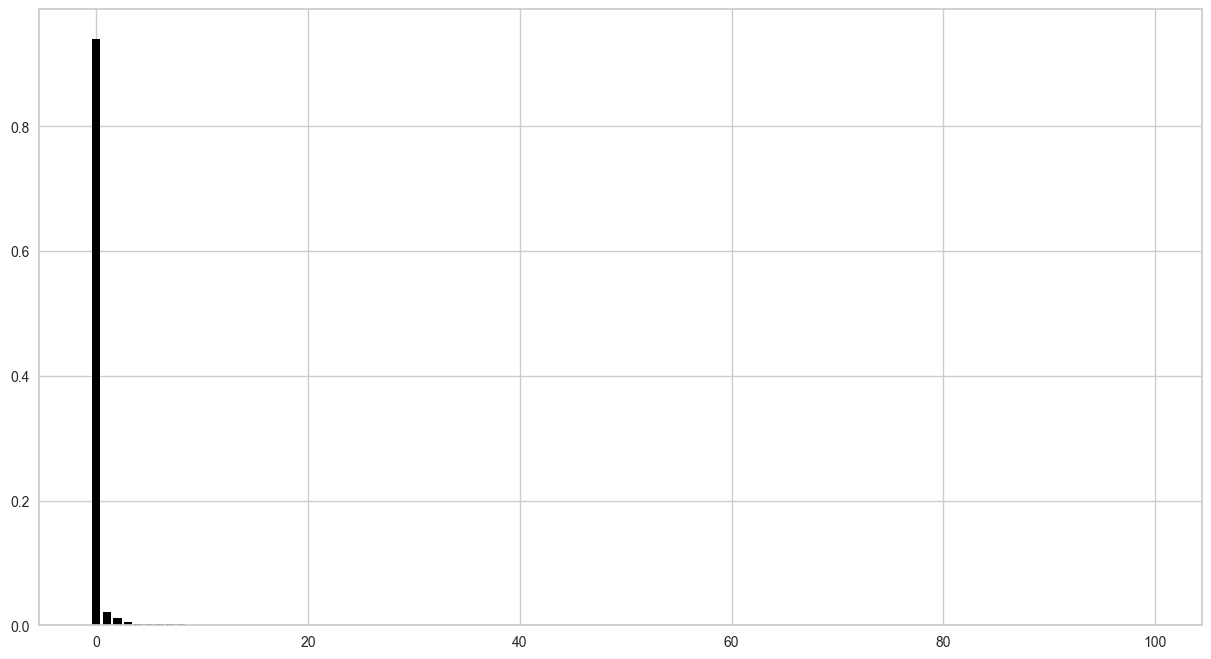

In [113]:
pca = PCA(n_components=df_leaf.shape[1])

principal_components = pca.fit_transform(df_leaf)

features = range( pca.n_components_)

plt.bar( features, pca.explained_variance_ratio_, color='black')

<AxesSubplot:xlabel='0', ylabel='1'>

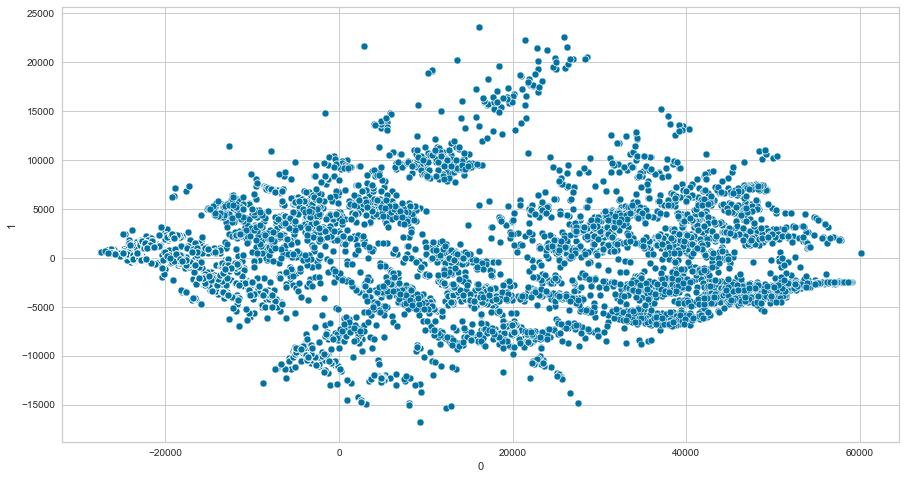

In [ ]:
df_pca=pd.DataFrame(principal_components)

sns.scatterplot(x=0 , y=1, data=df_pca)

In [ ]:
#This reduction was bad, the data is brarely separated

### 7.7.3 Tree Based Embedding + UMAP

p:\Python\GitHub\inside_repo\dev_env\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
C:\Users\kosmo\AppData\Local\Temp\ipykernel_8284\393240745.py:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x='embedding_0',y='embedding_1', data= embedding_tree_umap,


<Axes: xlabel='embedding_0', ylabel='embedding_1'>

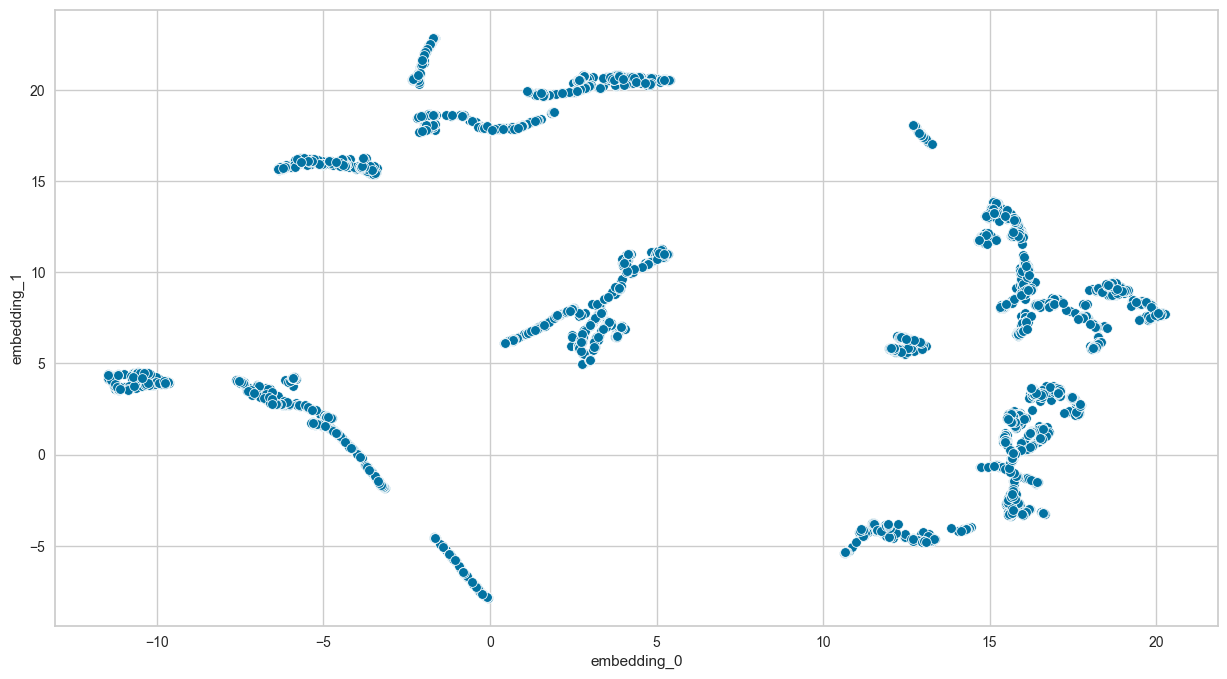

In [114]:
df_umap=df_leaf.copy()

reducer = umap.UMAP(n_neighbors=80, random_state=42)
embedding_tree_umap = pd.DataFrame(reducer.fit_transform( df_leaf ), columns=['embedding_0', 'embedding_1'])
     
# plot UMAP
sns.scatterplot(x='embedding_0',y='embedding_1', data= embedding_tree_umap,
                palette=sns.color_palette('hls'))

In [176]:
# The tree embedding + umap looks really good, because we can see clearly separeted groups, let's see the KMeans' performance.

[0.5082706, 0.54829377, 0.5427149, 0.5910101, 0.60051256, 0.5730672, 0.5660869]

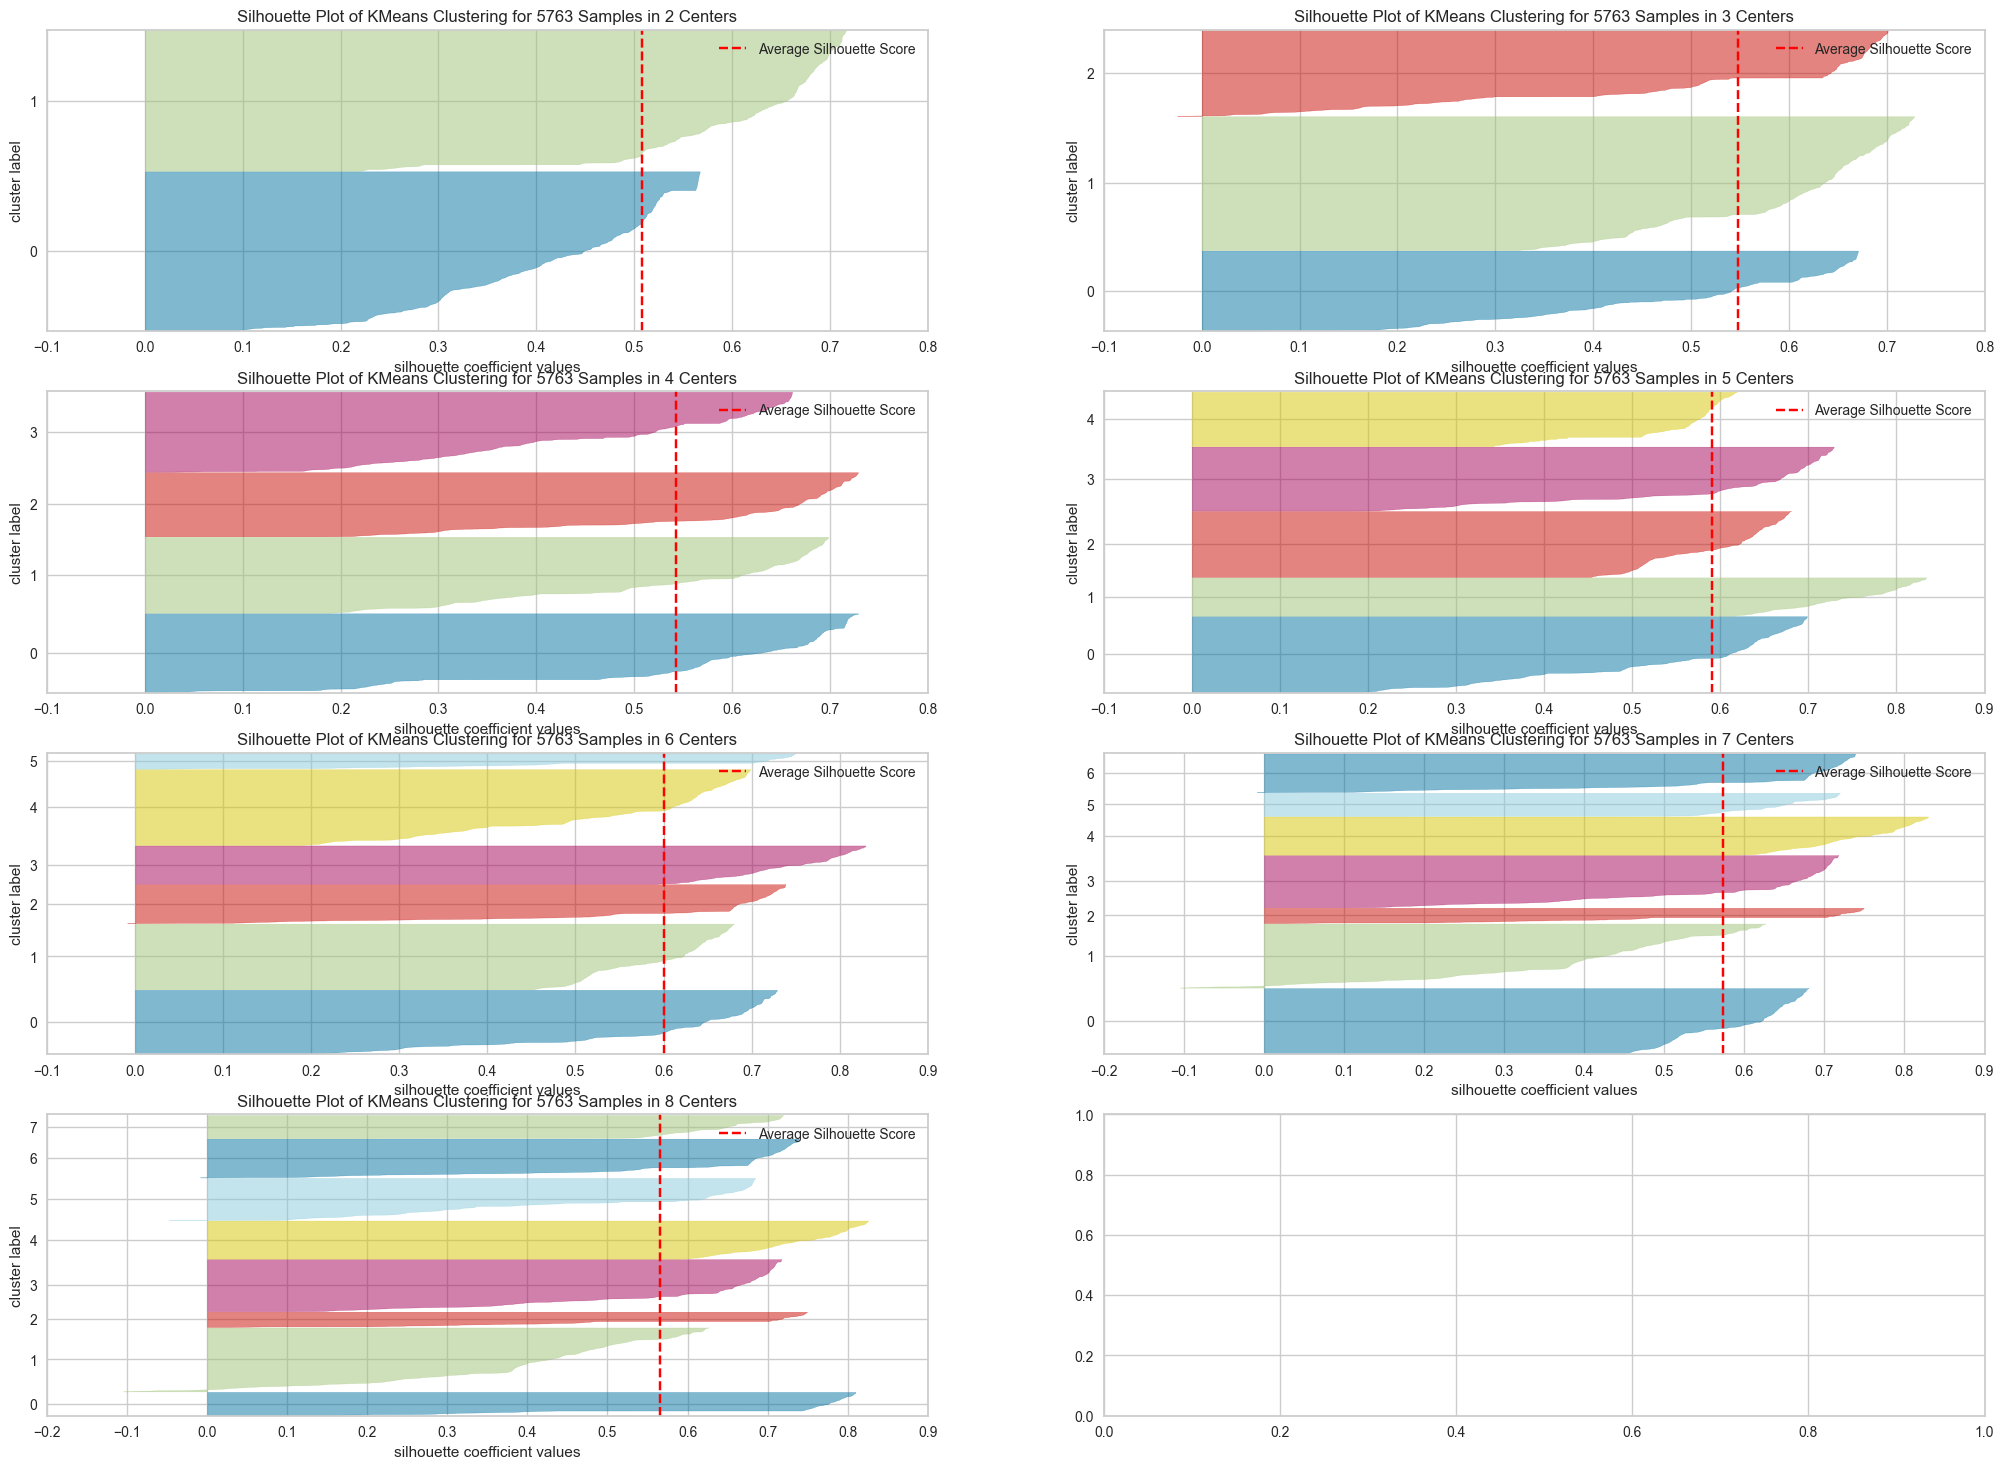

In [177]:
fig, ax = plt.subplots( 4, 2, figsize=(25, 18))

embedding_tree_umap_kmeans_list=[]
for k in clusters:
    km = c.KMeans(n_clusters=k, init="k-means++", n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(k, 2)
    vis_silhouette = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    vis_silhouette.fit(embedding_tree_umap)
    vis_silhouette.finalize()
    embedding_tree_umap_kmeans_list.append(vis_silhouette.silhouette_score_)
embedding_tree_umap_kmeans_list

## 7.8 Results

In [181]:
df_results = pd.DataFrame( 
    {'KMeans': kmeans_list, 
     'GMM': gmm_list, 
     'Hierarchical (ward linkage)': hc_list,
     "Tree embedding + TSNE + Kmeans": tree_tsne_scores,
     "Tree Embedding + UMAP + Kmeans": embedding_tree_umap_kmeans_list
   }
).T

df_results.columns = clusters
df_results.head()

,2,3,4,5,6,7,8
KMeans,0.395418,0.408045,0.409151,0.429588,0.426808,0.437430,0.429112
GMM,0.391457,0.359810,0.209701,0.262771,0.292059,0.230048,0.272132
Hierarchical (ward linkage),0.382377,0.383207,0.380610,0.430047,0.425108,0.415057,0.382416
Tree embedding + TSNE + Kmeans,0.367277,0.367277,0.367277,0.367277,0.367277,0.367277,0.367277
Tree Embedding + UMAP + Kmeans,0.508271,0.548294,0.542715,0.591010,0.600513,0.573067,0.566087


# 8.0  Final Model Training

In [117]:
Xfinal=X.copy()
df8=df7.copy()

p:\Python\GitHub\inside_repo\dev_env\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
C:\Users\kosmo\AppData\Local\Temp\ipykernel_8284\1498234839.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x='embedding_x',y='embedding_y',


<Axes: xlabel='embedding_x', ylabel='embedding_y'>

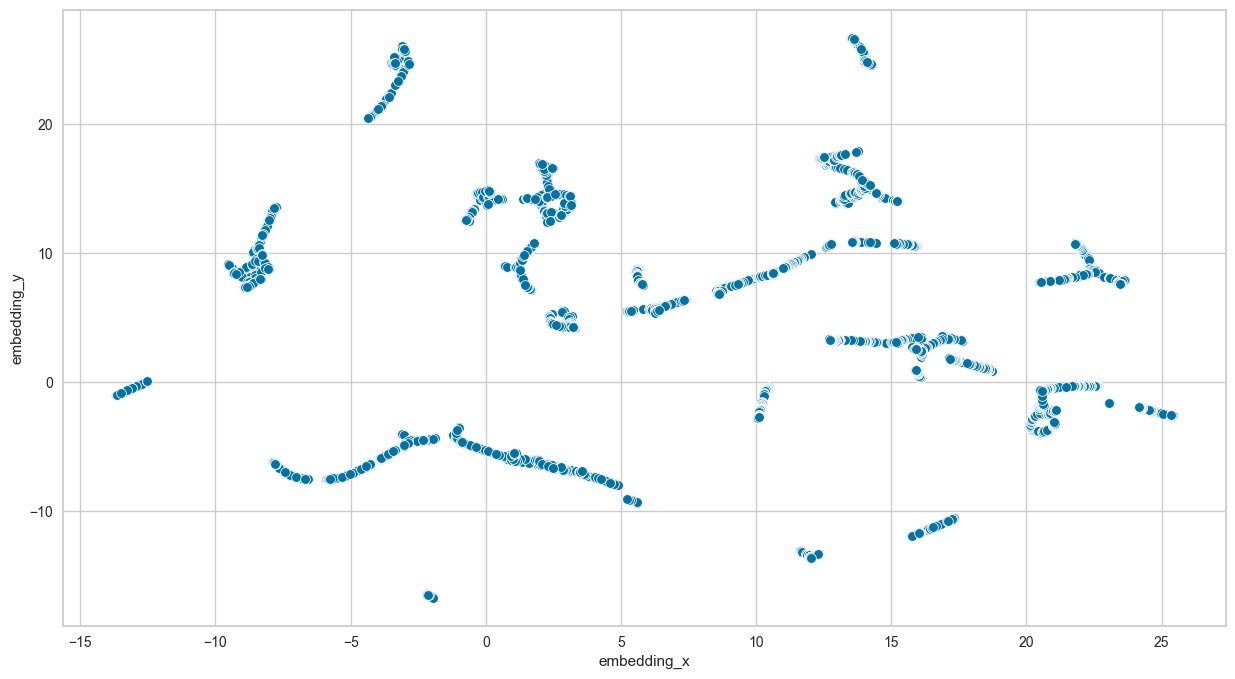

In [118]:
reducer = umap.UMAP(n_neighbors=200, random_state=42)
embedding_umap = pd.DataFrame( reducer.fit_transform( Xfinal ), columns=['embedding_x', 'embedding_y'] )

# plot UMAP
sns.scatterplot(x='embedding_x',y='embedding_y',
                palette=sns.color_palette('hls'),
                data=embedding_umap)

In [119]:
pickle.dump(reducer, open( "src/models/umap_reducer.pkl", "wb"))

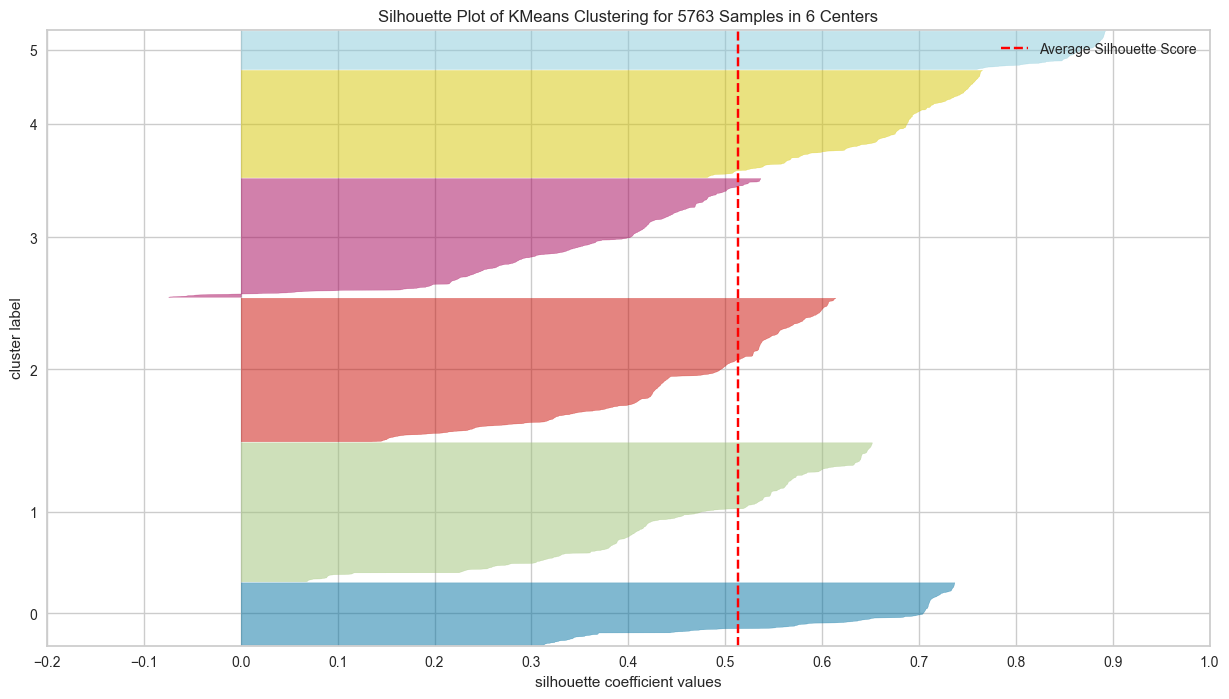

In [122]:
km_final = c.KMeans(n_clusters=6, init="k-means++", n_init=10, max_iter=100, random_state=42)
vis_silhouette = SilhouetteVisualizer(km_final, colors='yellowbrick')
vis_silhouette.fit(embedding_umap)
vis_silhouette.finalize()

In [121]:
pickle.dump(km_final, open("src/models/KMeans.pkl", "wb"))

# 9.0 Cluster Analysis and Suggested Action

In [ ]:
df9=df5.copy()
df9['profit'] = df9['gross_revenue'] - df9['gross_returns']
df9['cluster'] = km_final.fit_predict( embedding_umap )

In [ ]:
df9.groupby('cluster').median().style.highlight_max( color='purple', axis=0)

,customerid,gross_revenue,gross_returns,recencydays,qtd_items,qtd_items_return,avg_ticket,frequency,avg_basket_size,n_purchases_unique,profit
cluster,,,,,,,,,,,
0,80034.000000,181.120000,0.000000,364.000000,32.000000,0.000000,6.107051,1.000000,29.500000,1.000000,179.100000
1,17556.000000,351.670000,0.000000,154.000000,60.000000,0.000000,6.873333,1.000000,52.000000,1.000000,347.000000
2,15239.500000,1531.185000,4.330000,15.000000,189.000000,1.000000,8.813307,0.026017,73.750000,5.000000,1501.865000
3,17836.000000,332.745000,0.000000,277.000000,49.000000,0.000000,7.513607,1.000000,45.000000,1.000000,330.845000
4,17065.000000,268.830000,0.000000,18.000000,71.500000,0.000000,4.945108,1.000000,69.000000,1.000000,266.345000
5,15592.000000,749.780000,0.000000,65.000000,124.000000,0.000000,6.272021,0.025000,72.333333,2.000000,733.440000


## 9.1 Clusters Analysis

In [ ]:
aux1=df9.groupby('cluster').sum().assign(profit = lambda x: x['gross_revenue'] - x['gross_returns'])
aux1['profit_share'] = aux1['profit']/aux1['profit'].sum()
aux1 = pd.concat( [aux1, df9['cluster'].value_counts().sort_index().rename(index='cluster_size')]  ,axis=1)
aux1 = pd.concat( [aux1, df9['cluster'].value_counts(normalize=True).sort_index().rename(index='cluster_size_perc')]  ,axis=1)

aux1.style.highlight_max( color='purple', axis=0 )


,customerid,gross_revenue,gross_returns,recencydays,qtd_items,qtd_items_return,avg_ticket,frequency,avg_basket_size,n_purchases_unique,profit,profit_share,cluster_size,cluster_size_perc
0,14596334,290493.720000,1551.200000,100435.000000,28400.000000,302.000000,17292.206995,292.124675,28024.264706,319.000000,288942.520000,0.029759,277,0.048418
1,65351972,1038067.242000,10839.450000,213793.000000,156470.000000,1781.000000,32085.659277,1285.737939,136851.926587,1963.000000,1027227.792000,0.105797,1481,0.258871
2,26848936,6520283.371000,241019.450000,30063.000000,806517.000000,55091.000000,20567.322837,71.640981,208597.489363,13261.000000,6279263.921000,0.646718,1748,0.305541
3,40671113,589237.460000,6839.190000,252550.000000,79190.000000,1675.000000,13467.409283,814.617132,70099.086905,1073.000000,582398.270000,0.059983,898,0.156966
4,15638950,486355.030000,484.410000,7262.000000,57681.000000,233.000000,3539.839092,426.416667,55375.500000,436.000000,485870.620000,0.050041,404,0.070617
5,18911003,1061811.951000,16082.330000,65174.000000,203257.000000,4541.000000,8437.059755,257.702159,98655.017239,2737.000000,1045729.621000,0.107702,913,0.159587


### 